## Project: Predicting house sale prices  
**Data:** housing data for the city of Ames, Iowa, USA, 2006 to 2010  
**Data description:** https://s3.amazonaws.com/dq-content/307/data_description.txt  
**Source:** https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627  
**Source pdf:** https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true


#### Useful links

Inspiration notebooks:
* https://www.kaggle.com/code/solegalli/feature-engineering-for-house-price-modelling
* https://nycdatascience.com/blog/student-works/house-price-prediction-with-creative-feature-engineering-and-advanced-regression-techniques/
* https://rpubs.com/IsaacGabr/795734
* https://www.kaggle.com/code/modassirafzal/housing-top-3/notebook


Feature Engineering:
* https://towardsdatascience.com/churn-analysis-information-value-and-weight-of-evidence-6a35db8b9ec5  
* https://contrib.scikit-learn.org/category_encoders/woe.html  
* https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence  
* https://contrib.scikit-learn.org/category_encoders/polynomial.html  
* https://contrib.scikit-learn.org/category_encoders/targetencoder.html 
* https://stackoverflow.com/questions/46428870/how-to-handle-date-variable-in-machine-learning-data-pre-processing
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html
* https://www.lexjansen.com/sesug/2014/SD-20.pdf
* https://arxiv.org/pdf/2001.08025.pdf (Optbinning library)

Correlation for non-numeric data (Dython library):  
* https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

Variable standarization:  
http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf

Variable selection:  
* https://github.com/scikit-learn-contrib/boruta_py

Optimal Binning and WoE transformation for continuous dependent variable:
* http://gnpalencia.org/optbinning/binning_continuous.html
* https://www.listendata.com/2019/08/WOE-IV-Continuous-Dependent.html

Diagnostics:
* https://programminghistorian.org/en/lessons/linear-regression#step-8-evaluating-performance  
* https://online.stat.psu.edu/stat462/node/179/
* https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b
* https://medium.com/analytics-vidhya/multi-collinearity-key-aspect-of-regression-problem-9918a1a52559

Regression:
* https://en.wikipedia.org/wiki/Theil%E2%80%93Sen_estimator
* https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso


In [1]:
# Documentation
# https://thomas-cokelaer.info/tutorials/sphinx/docstring_python.html - 
# for how to docstring documents
# Let's have this project in Sphinx - it will be easier than writing 
# https://python.plainenglish.io/how-to-host-your-sphinx-documentation-on-github-550254f325ae
# https://stackoverflow.com/questions/41052221/what-is-the-difference-between-var-cvar-and-ivar-in-pythons-sphinx


### 1. Setting up environment

#### 1.1 Importing packages & setting-up parameters

In [2]:
# Set-up auto-reload functions for faster debugging 
# (automatically refreshes changes in subpackages codes)
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [3]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath(''))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [4]:
# Project packages import
import gp23package.data.make_dataset as gp23md
import gp23package.explore_visualise.eda as gp23eda
import gp23package.features.build_features as gp23feat
# Pylance highligting package issue (not to be worried about)
# https://github.com/microsoft/pylance-release/blob/main/TROUBLESHOOTING.md#unresolved-import-warnings

# Standard Python libraries import
from IPython.display import display, HTML #  tidied-up display
from time import time #  project timer
from itertools import chain # for list iterations

# plots
import matplotlib.pyplot as plt
import seaborn as sn

# Statistics
from scipy import stats
from scipy.stats import mstats

# Sklearn
from sklearn.feature_selection import (SelectKBest, chi2, f_regression, RFE, mutual_info_regression,
                                      SequentialFeatureSelector, SelectFromModel)
from sklearn.preprocessing import (normalize, MinMaxScaler)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score)
from sklearn.model_selection import (train_test_split, cross_val_score, KFold, GridSearchCV)
from sklearn.linear_model import (LinearRegression, Ridge, ElasticNet, Lasso, TheilSenRegressor, RANSACRegressor,
                                  HuberRegressor , SGDRegressor, Lars, ElasticNet, RidgeCV)

#statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels as sm
import statsmodels.stats.stattools as smt
import statsmodels.stats.diagnostic as smd

# Other
from dython import nominal # Correlations between categorical variables
from optbinning import ContinuousOptimalBinning # WoE transformations
import distfit #distribution fitting
import session_info # build and requirements.txt

# Necessary packages
import gp23package
import numpy as np
import pandas as pd
import copy # for deepcopy
import math
import pylab
import session_info # build and requirements.txt

#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250

In [5]:
# MANUAL_INPUT - mark of sections of code, that are not automated and have to be manually re-coded to new datasets.

# parameters
seed = 12345
target = 'SalePrice'
ID_vars = ['Order', 'PID']

# Non-numeric variables parameters

low_corr_category_parm = 0.1 # cut-off value for categorical variables correlation.
strong_correlation_param = 0.8 # cut-off value of Pearson correlation to indicate strong correlations
levels_discrete = 20 # how many levels (unique values) can a numeric variable have to be considered as discrete variable 
c_miss_cutoff = 0.8 # delete non-numeric variables that have more than c_miss_cutoff missing values

# Numeric variables paramaters

n_miss_cutoff = 0.25 # delete numeric variables that have more than n_miss_cutoff missing values
n_fill_cutoff = 0.05 # if missing values for numeric variables is ge than n_fill cutoff, use n_fill_method to impute values
n_fill_cutoff = 'mode' # numeric variables imputation method for missing values

#Train valid test split
test_split = 0.8 # 20% of total observations will be assigned to test dataset
valid_split = 0.8 # 20% of train_valid observations ( test_split * total observations) will be assigned to
# validation dataset

# Datasets explained

# Variable selection
low_variance_treshold = 0.01 # low variance treshold. 
# Variables that have less than low_variance_treshold variance in train_valid dataset will be dropped
kbestfeatures = 20 # 20 all variable selection methods will select kbestfeatures best variables

# data_transformed - data post missing values handling and inputation
# train - train dataset (post sampling)
# valid - valid dataset (post sampling)
# train_valid - concatenated train and valid datasets (post sampling). Used for CV purposes.
# test - holdout data for final accuracy confirmation.

#### 1.2 Starting project timer and exporting requirements

In [6]:
# Starting project timer
tic_all = time()

In [7]:
# Collecting packages info and saving to requirements.txt file
session_info.show(cpu = True, std_lib = True, dependencies = True, write_req_file = True,
                  req_file_name = 'requirements.txt')

#### 1.3 Importing and inspecting source data

In [8]:
data = gp23md.MakeDataset('AmesHousing.tsv').data
print(type(data))
display(HTML(data.head().to_html()))

<class 'pandas.core.frame.DataFrame'>


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [9]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

### 2. Exploratory Data Analysis (EDA)

#### 2.1 Non-numeric Data

In [10]:
# MANUAL_INPUT
# MS SubClass is a categorical variable stored as number - we will switch it to category
data["MS SubClass"] = 'C' + data["MS SubClass"].astype(str)

In [11]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables \n'.format(len(categorical)))

# Creating Series containing missing information
cat_miss = data[categorical].isnull().sum()/data.shape[0]

# changing missing values in categorical variables to 'Missing'
for var in categorical:
    data[var].fillna('Missing', inplace=True)

# Print basic info about variable - % of missing, # of unique values, unique values in data
for var in categorical:
    valueCounts = pd.concat([data[var].value_counts(), 
                data[var].value_counts(normalize=True).mul(100)],axis=1, keys=('counts', 'percentage'))
    print(var,'\n',len(data[var].unique()), 'unique values: ')
    display(HTML(valueCounts.to_html()))

There are 44 categorical variables 

MS SubClass 
 16 unique values: 


,counts,percentage
C20,1079,36.825939
C60,575,19.624573
C50,287,9.795222
C120,192,6.552901
C30,139,4.744027
C160,129,4.402730
C70,128,4.368601
C80,118,4.027304
C90,109,3.720137
C190,61,2.081911


MS Zoning 
 7 unique values: 


,counts,percentage
RL,2273,77.576792
RM,462,15.767918
FV,139,4.744027
RH,27,0.921502
C (all),25,0.853242
I (all),2,0.068259
A (agr),2,0.068259


Street 
 2 unique values: 


,counts,percentage
Pave,2918,99.590444
Grvl,12,0.409556


Alley 
 3 unique values: 


,counts,percentage
Missing,2732,93.242321
Grvl,120,4.095563
Pave,78,2.662116


Lot Shape 
 4 unique values: 


,counts,percentage
Reg,1859,63.447099
IR1,979,33.412969
IR2,76,2.593857
IR3,16,0.546075


Land Contour 
 4 unique values: 


,counts,percentage
Lvl,2633,89.863481
HLS,120,4.095563
Bnk,117,3.993174
Low,60,2.047782


Utilities 
 3 unique values: 


,counts,percentage
AllPub,2927,99.897611
NoSewr,2,0.068259
NoSeWa,1,0.034130


Lot Config 
 5 unique values: 


,counts,percentage
Inside,2140,73.037543
Corner,511,17.440273
CulDSac,180,6.143345
FR2,85,2.901024
FR3,14,0.477816


Land Slope 
 3 unique values: 


,counts,percentage
Gtl,2789,95.187713
Mod,125,4.266212
Sev,16,0.546075


Neighborhood 
 28 unique values: 


,counts,percentage
NAmes,443,15.119454
CollgCr,267,9.112628
OldTown,239,8.156997
Edwards,194,6.621160
Somerst,182,6.211604
NridgHt,166,5.665529
Gilbert,165,5.631399
Sawyer,151,5.153584
NWAmes,131,4.470990
SawyerW,125,4.266212


Condition 1 
 9 unique values: 


,counts,percentage
Norm,2522,86.075085
Feedr,164,5.597270
Artery,92,3.139932
RRAn,50,1.706485
PosN,39,1.331058
RRAe,28,0.955631
PosA,20,0.682594
RRNn,9,0.307167
RRNe,6,0.204778


Condition 2 
 8 unique values: 


,counts,percentage
Norm,2900,98.976109
Feedr,13,0.443686
Artery,5,0.170648
PosA,4,0.136519
PosN,4,0.136519
RRNn,2,0.068259
RRAe,1,0.034130
RRAn,1,0.034130


Bldg Type 
 5 unique values: 


,counts,percentage
1Fam,2425,82.764505
TwnhsE,233,7.952218
Duplex,109,3.720137
Twnhs,101,3.447099
2fmCon,62,2.116041


House Style 
 8 unique values: 


,counts,percentage
1Story,1481,50.546075
2Story,873,29.795222
1.5Fin,314,10.716724
SLvl,128,4.368601
SFoyer,83,2.832765
2.5Unf,24,0.819113
1.5Unf,19,0.648464
2.5Fin,8,0.273038


Roof Style 
 6 unique values: 


,counts,percentage
Gable,2321,79.215017
Hip,551,18.805461
Gambrel,22,0.750853
Flat,20,0.682594
Mansard,11,0.375427
Shed,5,0.170648


Roof Matl 
 8 unique values: 


,counts,percentage
CompShg,2887,98.532423
Tar&Grv,23,0.784983
WdShake,9,0.307167
WdShngl,7,0.238908
Membran,1,0.034130
ClyTile,1,0.034130
Roll,1,0.034130
Metal,1,0.034130


Exterior 1st 
 16 unique values: 


,counts,percentage
VinylSd,1026,35.017065
MetalSd,450,15.358362
HdBoard,442,15.085324
Wd Sdng,420,14.334471
Plywood,221,7.542662
CemntBd,126,4.300341
BrkFace,88,3.003413
WdShing,56,1.911263
AsbShng,44,1.501706
Stucco,43,1.467577


Exterior 2nd 
 17 unique values: 


,counts,percentage
VinylSd,1015,34.641638
MetalSd,447,15.255973
HdBoard,406,13.856655
Wd Sdng,397,13.549488
Plywood,274,9.351536
CmentBd,126,4.300341
Wd Shng,81,2.764505
Stucco,47,1.604096
BrkFace,47,1.604096
AsbShng,38,1.296928


Mas Vnr Type 
 6 unique values: 


,counts,percentage
None,1752,59.795222
BrkFace,880,30.034130
Stone,249,8.498294
BrkCmn,25,0.853242
Missing,23,0.784983
CBlock,1,0.034130


Exter Qual 
 4 unique values: 


,counts,percentage
TA,1799,61.399317
Gd,989,33.754266
Ex,107,3.651877
Fa,35,1.194539


Exter Cond 
 5 unique values: 


,counts,percentage
TA,2549,86.996587
Gd,299,10.204778
Fa,67,2.286689
Ex,12,0.409556
Po,3,0.102389


Foundation 
 6 unique values: 


,counts,percentage
PConc,1310,44.709898
CBlock,1244,42.457338
BrkTil,311,10.614334
Slab,49,1.672355
Stone,11,0.375427
Wood,5,0.170648


Bsmt Qual 
 6 unique values: 


,counts,percentage
TA,1283,43.788396
Gd,1219,41.604096
Ex,258,8.805461
Fa,88,3.003413
Missing,80,2.730375
Po,2,0.068259


Bsmt Cond 
 6 unique values: 


,counts,percentage
TA,2616,89.283276
Gd,122,4.163823
Fa,104,3.549488
Missing,80,2.730375
Po,5,0.170648
Ex,3,0.102389


Bsmt Exposure 
 5 unique values: 


,counts,percentage
No,1906,65.051195
Av,418,14.266212
Gd,284,9.692833
Mn,239,8.156997
Missing,83,2.832765


BsmtFin Type 1 
 7 unique values: 


,counts,percentage
GLQ,859,29.317406
Unf,851,29.044369
ALQ,429,14.641638
Rec,288,9.829352
BLQ,269,9.180887
LwQ,154,5.255973
Missing,80,2.730375


BsmtFin Type 2 
 7 unique values: 


,counts,percentage
Unf,2499,85.290102
Rec,106,3.617747
LwQ,89,3.037543
Missing,81,2.764505
BLQ,68,2.320819
ALQ,53,1.808874
GLQ,34,1.160410


Heating 
 6 unique values: 


,counts,percentage
GasA,2885,98.464164
GasW,27,0.921502
Grav,9,0.307167
Wall,6,0.204778
OthW,2,0.068259
Floor,1,0.034130


Heating QC 
 5 unique values: 


,counts,percentage
Ex,1495,51.023891
TA,864,29.488055
Gd,476,16.245734
Fa,92,3.139932
Po,3,0.102389


Central Air 
 2 unique values: 


,counts,percentage
Y,2734,93.31058
N,196,6.68942


Electrical 
 6 unique values: 


,counts,percentage
SBrkr,2682,91.535836
FuseA,188,6.416382
FuseF,50,1.706485
FuseP,8,0.273038
Missing,1,0.034130
Mix,1,0.034130


Kitchen Qual 
 5 unique values: 


,counts,percentage
TA,1494,50.989761
Gd,1160,39.590444
Ex,205,6.996587
Fa,70,2.389078
Po,1,0.034130


Functional 
 8 unique values: 


,counts,percentage
Typ,2728,93.105802
Min2,70,2.389078
Min1,65,2.218430
Mod,35,1.194539
Maj1,19,0.648464
Maj2,9,0.307167
Sev,2,0.068259
Sal,2,0.068259


Fireplace Qu 
 6 unique values: 


,counts,percentage
Missing,1422,48.532423
Gd,744,25.392491
TA,600,20.477816
Fa,75,2.559727
Po,46,1.569966
Ex,43,1.467577


Garage Type 
 7 unique values: 


,counts,percentage
Attchd,1731,59.078498
Detchd,782,26.689420
BuiltIn,186,6.348123
Missing,157,5.358362
Basment,36,1.228669
2Types,23,0.784983
CarPort,15,0.511945


Garage Finish 
 4 unique values: 


,counts,percentage
Unf,1231,42.013652
RFn,812,27.713311
Fin,728,24.846416
Missing,159,5.426621


Garage Qual 
 6 unique values: 


,counts,percentage
TA,2615,89.249147
Missing,159,5.426621
Fa,124,4.232082
Gd,24,0.819113
Po,5,0.170648
Ex,3,0.102389


Garage Cond 
 6 unique values: 


,counts,percentage
TA,2665,90.955631
Missing,159,5.426621
Fa,74,2.525597
Gd,15,0.511945
Po,14,0.477816
Ex,3,0.102389


Paved Drive 
 3 unique values: 


,counts,percentage
Y,2652,90.511945
N,216,7.372014
P,62,2.116041


Pool QC 
 5 unique values: 


,counts,percentage
Missing,2917,99.556314
Ex,4,0.136519
Gd,4,0.136519
TA,3,0.102389
Fa,2,0.068259


Fence 
 5 unique values: 


,counts,percentage
Missing,2358,80.477816
MnPrv,330,11.262799
GdPrv,118,4.027304
GdWo,112,3.822526
MnWw,12,0.409556


Misc Feature 
 6 unique values: 


,counts,percentage
Missing,2824,96.382253
Shed,95,3.242321
Gar2,5,0.170648
Othr,4,0.136519
Elev,1,0.034130
TenC,1,0.034130


Sale Type 
 10 unique values: 


,counts,percentage
WD,2536,86.552901
New,239,8.156997
COD,87,2.969283
ConLD,26,0.887372
CWD,12,0.409556
ConLI,9,0.307167
ConLw,8,0.273038
Oth,7,0.238908
Con,5,0.170648
VWD,1,0.034130


Sale Condition 
 6 unique values: 


,counts,percentage
Normal,2413,82.354949
Partial,245,8.361775
Abnorml,190,6.484642
Family,46,1.569966
Alloca,24,0.819113
AdjLand,12,0.409556


In [12]:
# Removing non-numeric variables with too much missing data
print('Variable name   % of missing\n',cat_miss[cat_miss > c_miss_cutoff],'\n',cat_miss[cat_miss > c_miss_cutoff].shape[0],'variables removed.')
for var in cat_miss[cat_miss > c_miss_cutoff].index:
    try:
        categorical.remove(var)
    except:
        print('Variable',var,'is already removed from categorical list.')

print('\nThere are {} categorical variables left for analysis.\n'.format(len(categorical)))

Variable name   % of missing
 Alley           0.932423
Pool QC         0.995563
Fence           0.804778
Misc Feature    0.963823
dtype: float64 
 4 variables removed.

There are 40 categorical variables left for analysis.



In [13]:
# MANUAL_INPUT
# Below variables are numbers stored as string or can be easily translated to numbers (Central Air to binary) 

# Variable value dictionary 
# Ex - Excellent
# Gd - Good
# TA - Typical/Average
# Fa - Fair
# Po - Poor
# Bsmt Qual missing - no basement
# Bsmt Cond missing - no basement
# Garage Qual missing - no garage
# Garage Cond missing - no garage
# Pool QC missing - no pool
# Fireplace Qu missing - no fireplace

for var in ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Garage Qual', 'Garage Cond', 
    'Fireplace Qu']:
    data[var].replace(['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5], inplace=True)
    data[var]=data[var].astype(int)
    try:
        categorical.remove(var)
    except:
        print('Variable',var,'is already removed from categorical list.')    
    

data['Central Air'].replace(['Y','N'],[1, 0], inplace=True)
data['Central Air']=data['Central Air'].astype(int)
try:
    categorical.remove('Central Air')
except:
    print('Variable Central Air is already removed from categorical list.')

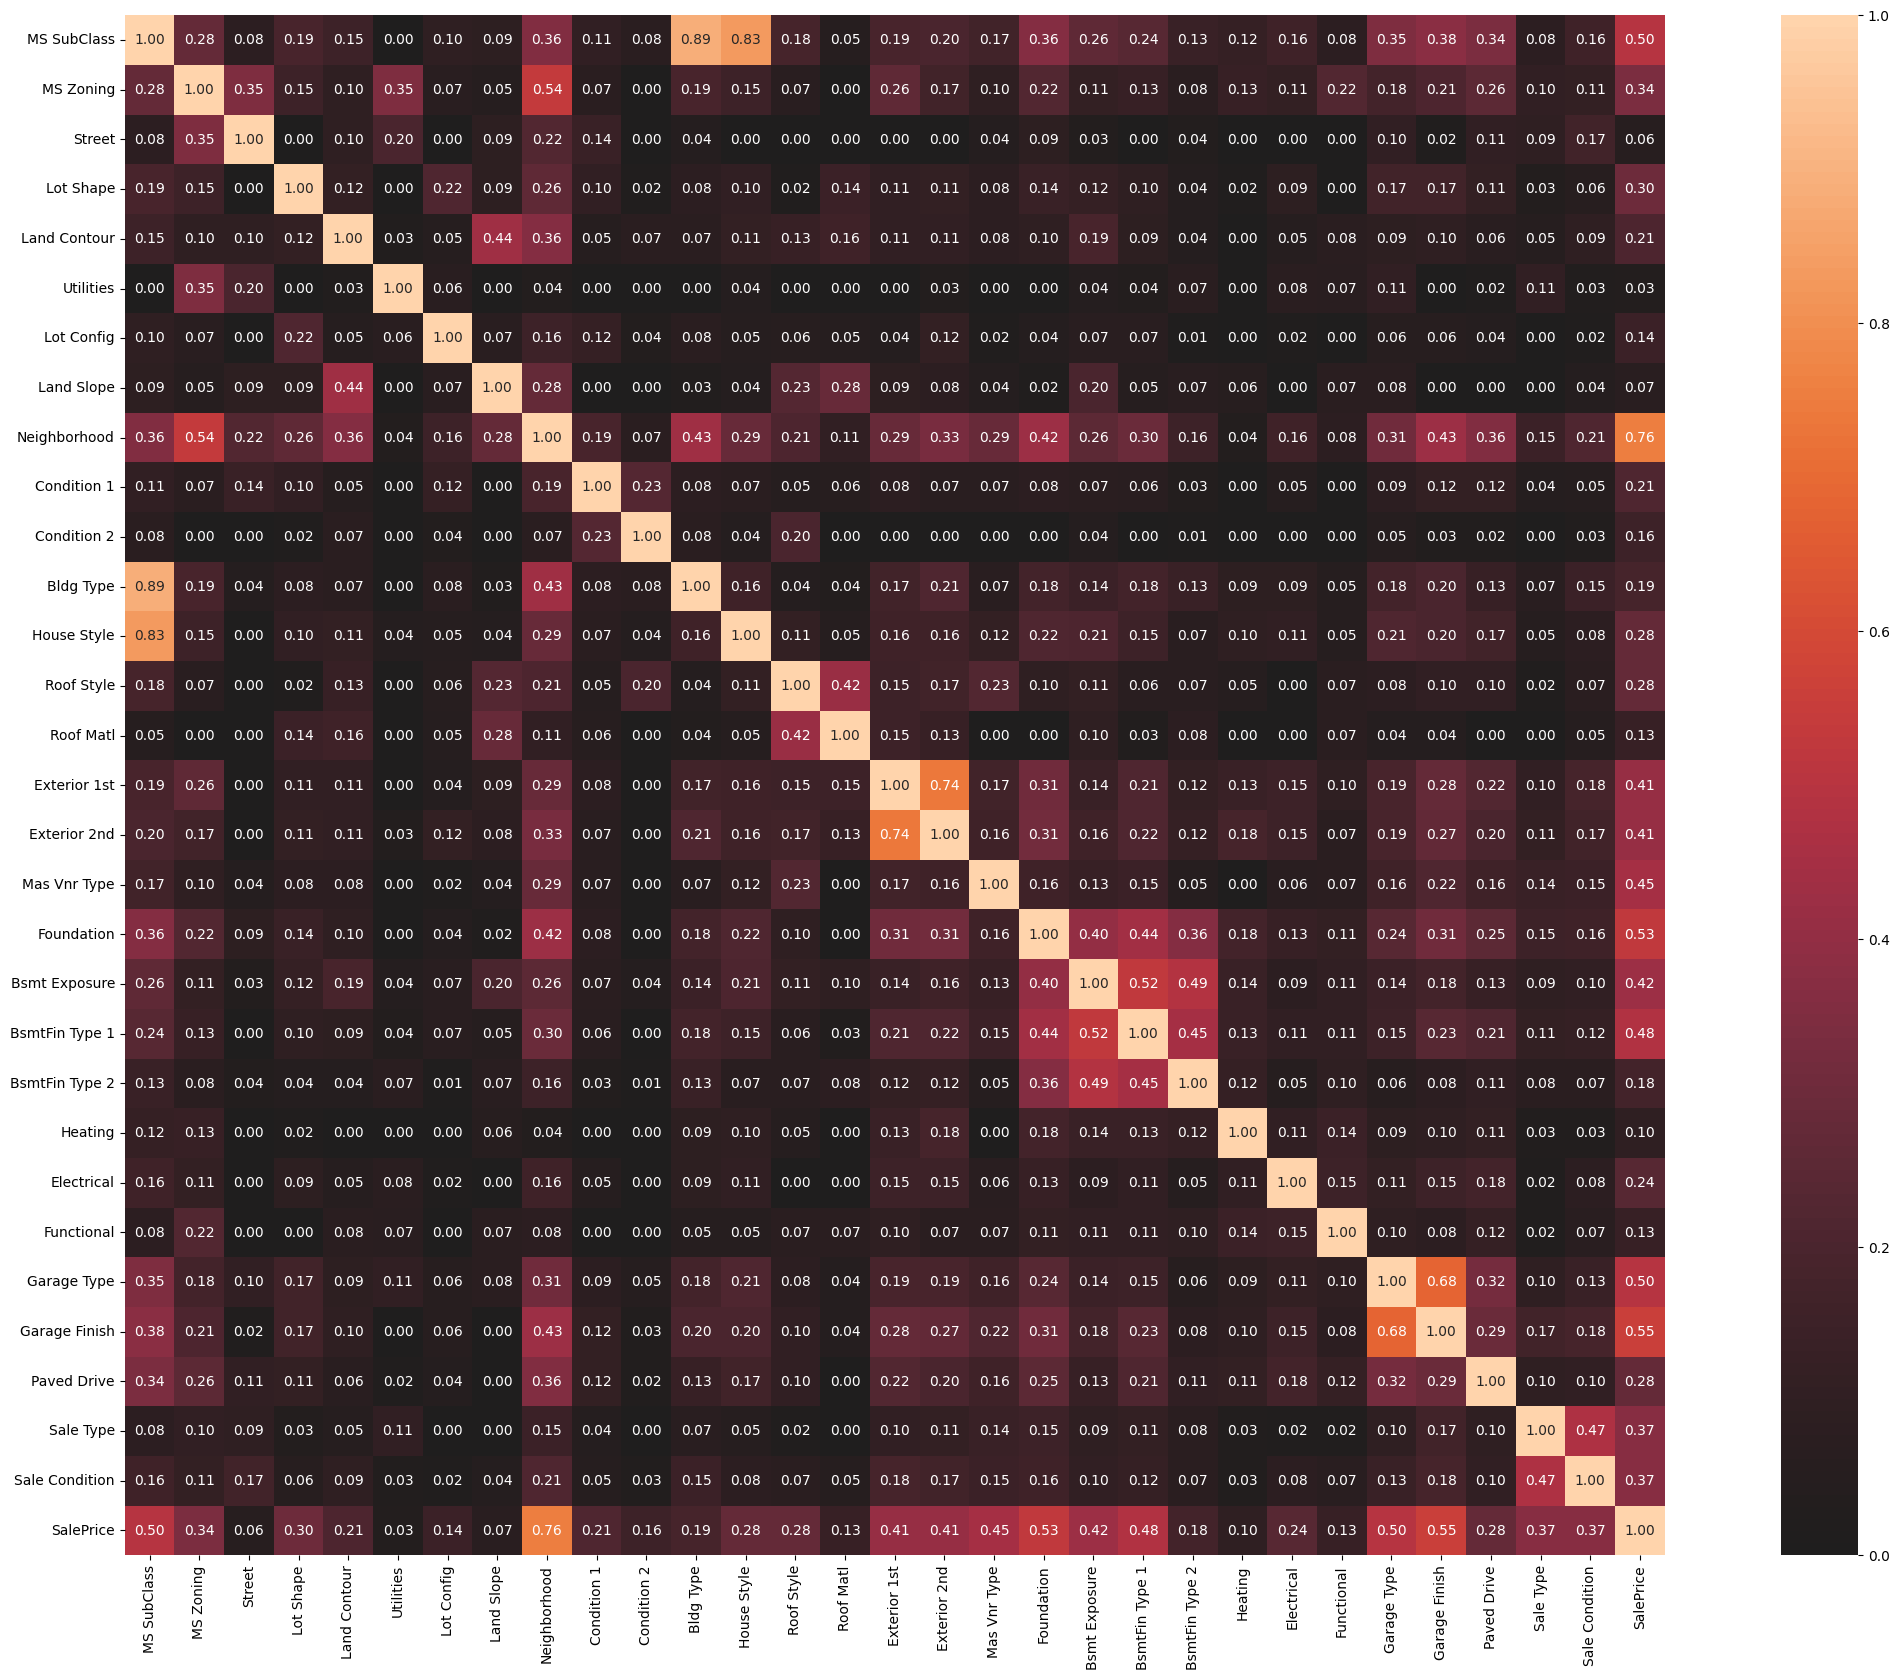

In [14]:
# Correlation for non-numeric variables
# Dython nominal.associations works well with object-type variables, may cause trouble with string-type variables
categorical.append(target)
corr_nom = nominal.associations(data[categorical],figsize=(30,20))
categorical.remove(target)

In [15]:
# Correlation of non-numeric data with target in descending order
category_correlations = corr_nom["corr"][target].sort_values(ascending=False)
print(category_correlations)

SalePrice         1.000000
Neighborhood      0.757151
Garage Finish     0.554700
Foundation        0.529272
Garage Type       0.498820
MS SubClass       0.497762
BsmtFin Type 1    0.477178
Mas Vnr Type      0.445932
Bsmt Exposure     0.424721
Exterior 1st      0.412103
Exterior 2nd      0.411566
Sale Type         0.373915
Sale Condition    0.370903
MS Zoning         0.340301
Lot Shape         0.302770
Roof Style        0.279362
House Style       0.278276
Paved Drive       0.276871
Electrical        0.242098
Condition 1       0.212481
Land Contour      0.209026
Bldg Type         0.185816
BsmtFin Type 2    0.175999
Condition 2       0.156105
Lot Config        0.144932
Functional        0.132555
Roof Matl         0.126682
Heating           0.098599
Land Slope        0.068563
Street            0.059519
Utilities         0.032503
Name: SalePrice, dtype: float64


In [16]:
# Removing non-numeric variables with correlation to target variable that is lower than parameter low_corr_category_param
# Warning: this might save some time for linear models, however you might lose significant information and not recommended 
# for non-linear approaches
for item in category_correlations[category_correlations < low_corr_category_parm].index:
    categorical.remove(item)
    
print('There are {} categorical variables left'.format(len(categorical)))

There are 26 categorical variables left


26 categorical variables will be considered for modeling purposes.  
In order to fit them into model we might consider target encoding, one-hot encoding or some other transformation.

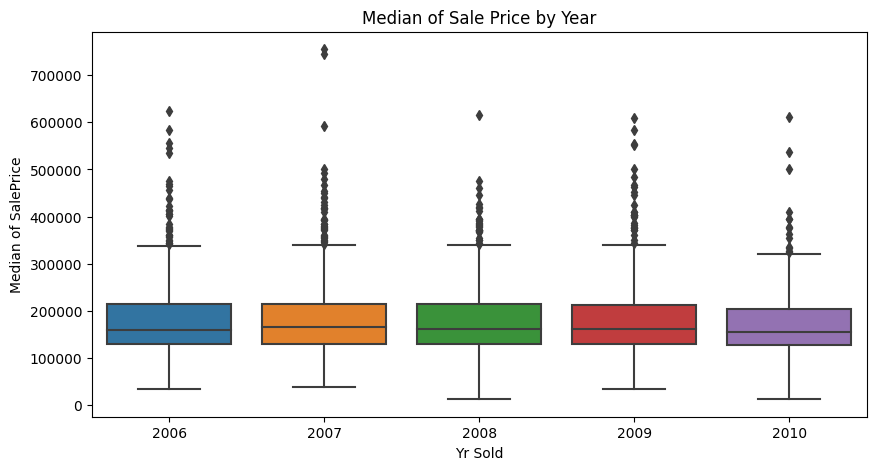

Yr Sold 
 5 unique values: 


,counts,percentage
2007,694,23.686007
2009,648,22.116041
2006,625,21.331058
2008,622,21.228669
2010,341,11.638225


In [17]:
# MANUAL_INPUT
# Visual investigation of target data by groups
gp23eda.var_boxplot(var = 'Yr Sold', data = data, target = target, title = 'Median of Sale Price by Year')

We can see that median sale price by ear of selling is more or less on the same level with slight decrease in 2008 (potentially because of subprime mortgage lending crisis), but recovering in upcoming years.

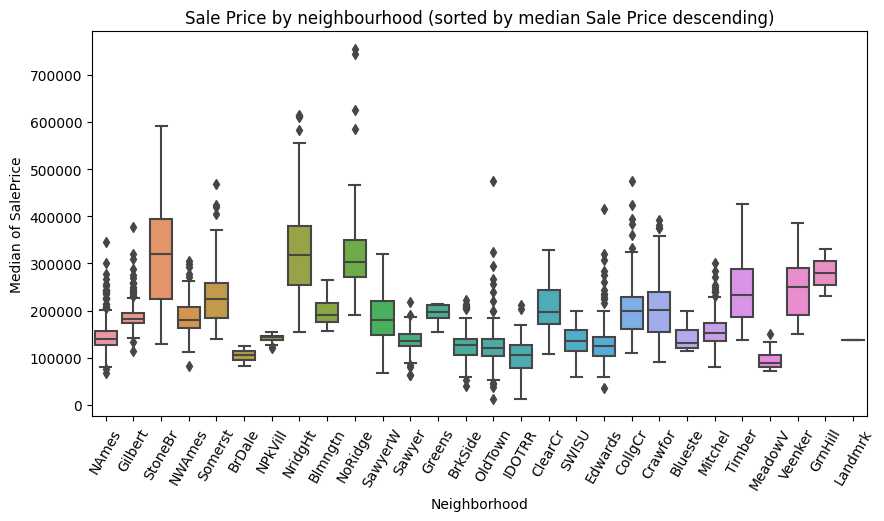

Neighborhood 
 28 unique values: 


,counts,percentage
NAmes,443,15.119454
CollgCr,267,9.112628
OldTown,239,8.156997
Edwards,194,6.621160
Somerst,182,6.211604
NridgHt,166,5.665529
Gilbert,165,5.631399
Sawyer,151,5.153584
NWAmes,131,4.470990
SawyerW,125,4.266212


In [18]:
# MANUAL_INPUT
gp23eda.var_boxplot(var =  "Neighborhood", data = data, target = target, 
        title = 'Sale Price by neighbourhood (sorted by median Sale Price descending)', xrotate = 60)

We can see that there is huge sale price variance based on neighbourhood with median price in the most expensive neighbourhood (Stone Br) more than 3x exceeding median price in the cheapest neighbourhood (Meadow V).

Small size categories have potential to be grouped together as "other" (reduce outlier influence).


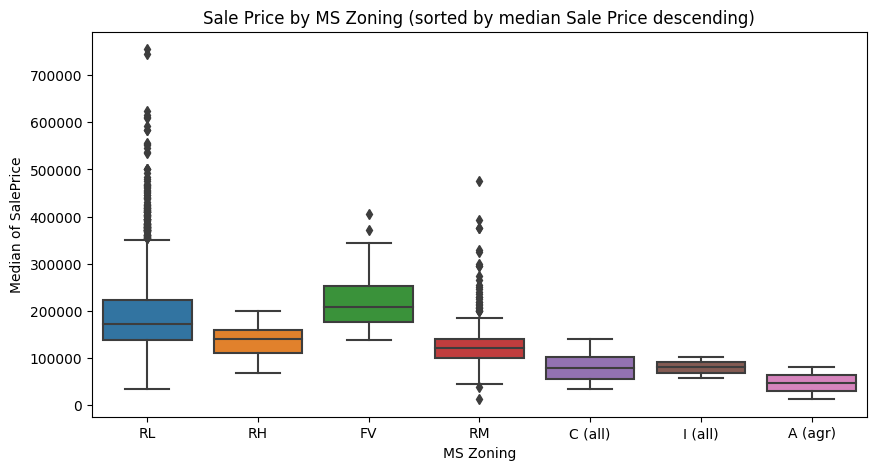

MS Zoning 
 7 unique values: 


,counts,percentage
RL,2273,77.576792
RM,462,15.767918
FV,139,4.744027
RH,27,0.921502
C (all),25,0.853242
I (all),2,0.068259
A (agr),2,0.068259


In [19]:
# MANUAL_INPUT
gp23eda.var_boxplot(var =  "MS Zoning", data = data, target = target, 
        title = 'Sale Price by MS Zoning (sorted by median Sale Price descending)')

High price differentiation based on MS Zoning, with most expensive zoning being:
1) Floating Village Residential  
2) Residential Low Density  
3) Residential High Density  
4) Residential Medium density  
5) Industrial  
6) Commercial  
7) Agricultural

Potential for grouping of less frequent categories ( C (all), I (all), A (agr) )

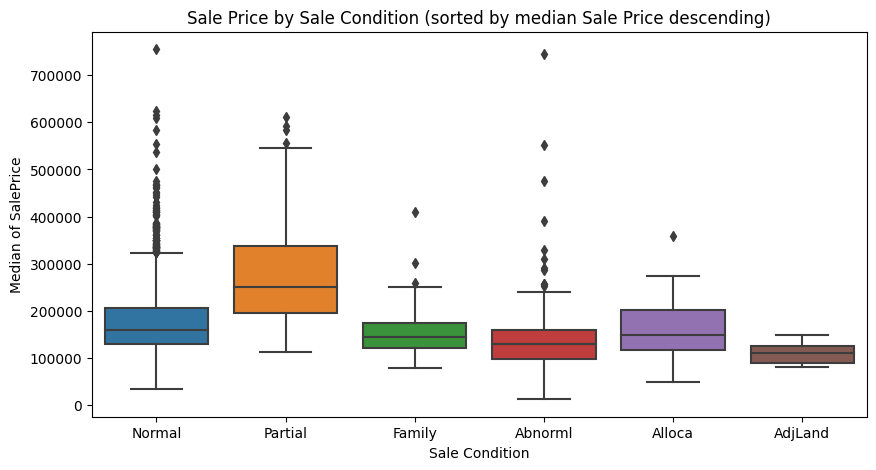

Sale Condition 
 6 unique values: 


,counts,percentage
Normal,2413,82.354949
Partial,245,8.361775
Abnorml,190,6.484642
Family,46,1.569966
Alloca,24,0.819113
AdjLand,12,0.409556


In [20]:
# MANUAL_INPUT
gp23eda.var_boxplot(var =  "Sale Condition", data = data, target = target, 
        title = 'Sale Price by Sale Condition (sorted by median Sale Price descending)')

Highest prices are associated with selling new houses (Partial), followed by normal sale type (Normal) and condo sale (Allocation).

Potential for joining Adjoining Land Purchases ('AdjLand') and Sale between family members ('Family') categories.

### 2.2 Numeric data

In [21]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 48 numerical variables


In [22]:
discrete = []
for var in numerical:
    if len(data[var].unique())< levels_discrete:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

Overall Qual  values:  [ 6  5  7  8  9  4  3  2 10  1]
Overall Cond  values:  [5 6 7 2 8 4 9 3 1]
Exter Qual  values:  [3 4 5 2]
Exter Cond  values:  [3 4 2 1 5]
Bsmt Qual  values:  [3 4 5 0 2 1]
Bsmt Cond  values:  [4 3 0 1 2 5]
Heating QC  values:  [2 3 5 4 1]
Central Air  values:  [1 0]
Bsmt Full Bath  values:  [ 1.  0.  2.  3. nan]
Bsmt Half Bath  values:  [ 0.  1. nan  2.]
Full Bath  values:  [1 2 3 0 4]
Half Bath  values:  [0 1 2]
Bedroom AbvGr  values:  [3 2 1 4 6 5 0 8]
Kitchen AbvGr  values:  [1 2 3 0]
Kitchen Qual  values:  [3 4 5 2 1]
TotRms AbvGrd  values:  [ 7  5  6  8  4 12 10 11  9  3 13  2 15 14]
Fireplaces  values:  [2 0 1 3 4]
Fireplace Qu  values:  [4 0 3 1 5 2]
Garage Cars  values:  [ 2.  1.  3.  0.  4.  5. nan]
Garage Qual  values:  [3 0 2 4 5 1]
Garage Cond  values:  [3 0 2 4 5 1]
Pool Area  values:  [  0 144 480 576 555 368 444 228 561 519 648 800 512 738]
Mo Sold  values:  [ 5  6  4  3  1  2  7 10  8 11  9 12]
Yr Sold  values:  [2010 2009 2008 2007 2006]
There a

In [23]:
# temp list - additional list of variables (expert decision) to be excluded from continuous variables
temp_list = []
for item in ID_vars:
    temp_list.append(item)

continuous = [var for var in numerical if var not in discrete and var not in temp_list]
continuous

['Lot Frontage',
 'Lot Area',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Yr Blt',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Misc Val',
 'SalePrice']

#### 2.2.1 Numeric variables - Missing values handling
Usually this would be done on train & valid dataset only, excluding test/holdout data in order to prevent information leakage. However because of using mode value for missing data I am relaxing this requirement under assumption that train/valid and test data variable values distribution is similar.

In [24]:
transformation = gp23feat.FeatureCorrection(data_in = data, na_var_list = discrete, numerical_var_list = numerical)
data_transformed = transformation.output()

Order - 0.0% of missing values. Variable copied.
PID - 0.0% of missing values. Variable copied.
Lot Frontage - 16.7235% of missing values. Variable copied.
Lot Area - 0.0% of missing values. Variable copied.
Overall Qual - 0.0% of missing values. Variable copied.
Overall Cond - 0.0% of missing values. Variable copied.
Year Built - 0.0% of missing values. Variable copied.
Year Remod/Add - 0.0% of missing values. Variable copied.
Mas Vnr Area - 0.785% of missing values. They are replaced with mode value - 0.0
Mas Vnr Area_NA is created to indicate missing values of original variable.
Mas Vnr Area_NA added to na_var_list.
Exter Qual - 0.0% of missing values. Variable copied.
Exter Cond - 0.0% of missing values. Variable copied.
Bsmt Qual - 0.0% of missing values. Variable copied.
Bsmt Cond - 0.0% of missing values. Variable copied.
BsmtFin SF 1 - 0.0341% of missing values. They are replaced with mode value - 0.0
BsmtFin SF 1_NA is created to indicate missing values of original variable.
B

In [25]:
data_transformed.head()

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
0,1,526301100,141.0,31770,6,5,1960,1960,0,112.0,3,3,3,4,0,639.0,0,0.0,0,441.0,0,1080.0,2,1,1656,0,0,1656,0,1.0,0,0.0,1,0,3,1,3,7,2,4,1960.0,0,2.0,0,528.0,3,3,210,62,0,0,0,0,0,5,2010,215000,C20,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,Stone,CBlock,Gd,BLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,P,Missing,Missing,Missing,WD,Normal
1,2,526350040,80.0,11622,5,6,1961,1961,0,0.0,3,3,3,3,0,468.0,0,144.0,0,270.0,0,882.0,3,1,896,0,0,896,0,0.0,0,0.0,1,0,2,1,3,5,0,0,1961.0,0,1.0,0,730.0,3,3,140,0,0,0,120,0,0,6,2010,105000,C20,RH,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,No,Rec,LwQ,GasA,SBrkr,Typ,Attchd,Unf,Y,Missing,MnPrv,Missing,WD,Normal
2,3,526351010,81.0,14267,6,6,1958,1958,0,108.0,3,3,3,3,0,923.0,0,0.0,0,406.0,0,1329.0,3,1,1329,0,0,1329,0,0.0,0,0.0,1,1,3,1,4,6,0,0,1958.0,0,1.0,0,312.0,3,3,393,36,0,0,0,0,12500,6,2010,172000,C20,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,CBlock,No,ALQ,Unf,GasA,SBrkr,Typ,Attchd,Unf,Y,Missing,Missing,Gar2,WD,Normal
3,4,526353030,93.0,11160,7,5,1968,1968,0,0.0,4,3,3,3,0,1065.0,0,0.0,0,1045.0,0,2110.0,5,1,2110,0,0,2110,0,1.0,0,0.0,2,1,3,1,5,8,2,3,1968.0,0,2.0,0,522.0,3,3,0,0,0,0,0,0,0,4,2010,244000,C20,RL,Pave,Missing,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,None,CBlock,No,ALQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,Missing,Missing,WD,Normal
4,5,527105010,74.0,13830,5,5,1997,1998,0,0.0,3,3,4,3,0,791.0,0,0.0,0,137.0,0,928.0,4,1,928,701,0,1629,0,0.0,0,0.0,2,1,3,1,3,6,1,3,1997.0,0,2.0,0,482.0,3,3,212,34,0,0,0,0,0,3,2010,189900,C60,RL,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,No,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,MnPrv,Missing,WD,Normal


In [26]:
#MANUAL_INPUT
# Check Garage Cars and Garage Area - mode imputation seems to be invalid here
print('Data inconsistencies: Checking automatic fill for missing values in Garage Cars and Garage Area')
display(HTML(data_transformed[(data_transformed['Garage Cars_NA']==1) | (data_transformed['Garage Area_NA']==1)].to_html()))
print('2 Garage cars and no garage, does not make much sense. I will change Garage Cars value to 0')
data_transformed.loc[data_transformed['Garage Cars_NA'] == 1, 'Garage Cars'] = 0
print(data_transformed[["Garage Cars","Order"]][data_transformed['Garage Cars_NA']==1])

Data inconsistencies: Checking automatic fill for missing values in Garage Cars and Garage Area


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
2236,2237,910201180,50.0,9060,5,6,1923,1999,0,0.0,3,3,4,3,0,548.0,0,0.0,0,311.0,0,859.0,5,1,942,886,0,1828,0,0.0,0,0.0,2,0,3,1,4,6,0,0,NaN,1,2.0,1,0.0,0,0,174,0,212,0,0,0,0,3,2007,150909,C70,RM,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Plywood,None,BrkTil,No,ALQ,Unf,GasA,SBrkr,Typ,Detchd,Missing,Y,Missing,MnPrv,Missing,WD,Alloca


2 Garage cars and no garage, does not make much sense. I will change Garage Cars value to 0
      Garage Cars  Order
2236          0.0   2237


In [27]:
#MANUAL_INPUT
print('Data inconsistencies: checking if there are any sale records with date of refubrishment later than date of sale')
display(HTML(data_transformed[data_transformed["Yr Sold"]<data_transformed["Year Remod/Add"]].to_html()))

print('Data inconsistencies: checking if there are any sale records with date of construction later than date of sale')
display(HTML(data_transformed[data_transformed["Yr Sold"]<data_transformed["Year Built"]].to_html()))

print('Data inconsistencies: checking if there are any sale records with date of construction later than date of refubrishment')
display(HTML(data_transformed[data_transformed["Year Built"]>data_transformed["Year Remod/Add"]].to_html()))

print('All 4 (obs 2810 appears in both cases) observations contain data "from the future" (past point of sale), so we will delete them')
data_transformed = data_transformed.drop(data_transformed.index[[850,1702, 2180, 2181]])

Data inconsistencies: checking if there are any sale records with date of refubrishment later than date of sale


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
1702,1703,528120010,134.0,16659,8,5,2007,2008,0,0.0,4,3,4,3,0,0.0,0,0.0,0,1582.0,0,1582.0,5,1,1582,570,0,2152,0,0.0,0,0.0,2,1,3,1,4,7,1,4,2007.0,0,2.0,0,728.0,3,3,0,368,0,0,0,0,0,6,2007,260116,C60,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,No,Unf,Unf,GasA,SBrkr,Typ,Detchd,Unf,Y,Missing,Missing,Missing,New,Partial
2180,2181,908154195,128.0,39290,10,5,2008,2009,0,1224.0,5,3,5,3,0,4010.0,0,0.0,0,1085.0,0,5095.0,5,1,5095,0,0,5095,0,1.0,0,1.0,2,1,2,1,5,15,2,4,2008.0,0,3.0,0,1154.0,3,3,546,484,0,0,0,0,17000,10,2007,183850,C20,RL,Pave,Missing,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,PConc,Gd,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,Missing,Elev,New,Partial
2181,2182,908154205,130.0,40094,10,5,2007,2008,0,762.0,5,3,5,3,0,2260.0,0,0.0,0,878.0,0,3138.0,5,1,3138,1538,0,4676,0,1.0,0,0.0,3,1,3,1,5,11,1,4,2007.0,0,3.0,0,884.0,3,3,208,406,0,0,0,0,0,10,2007,184750,C60,RL,Pave,Missing,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,PConc,Gd,GLQ,Unf,GasA,SBrkr,Typ,BuiltIn,Fin,Y,Missing,Missing,Missing,New,Partial


Data inconsistencies: checking if there are any sale records with date of construction later than date of sale


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
2180,2181,908154195,128.0,39290,10,5,2008,2009,0,1224.0,5,3,5,3,0,4010.0,0,0.0,0,1085.0,0,5095.0,5,1,5095,0,0,5095,0,1.0,0,1.0,2,1,2,1,5,15,2,4,2008.0,0,3.0,0,1154.0,3,3,546,484,0,0,0,0,17000,10,2007,183850,C20,RL,Pave,Missing,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,PConc,Gd,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Fin,Y,Missing,Missing,Elev,New,Partial


Data inconsistencies: checking if there are any sale records with date of construction later than date of refubrishment


,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
850,851,907194160,65.0,10739,7,5,2002,2001,0,68.0,4,3,4,3,0,1259.0,0,0.0,0,172.0,0,1431.0,5,1,1444,0,0,1444,0,1.0,0,0.0,2,0,3,1,4,6,0,0,2002.0,0,2.0,0,577.0,3,3,144,40,0,0,0,0,0,4,2009,203000,C20,RL,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,No,GLQ,Unf,GasA,SBrkr,Typ,Attchd,RFn,Y,Missing,Missing,Missing,WD,Normal


All 4 (obs 2810 appears in both cases) observations contain data "from the future" (past point of sale), so we will delete them


#### 2.3 Features Generation - expert domain

In [28]:
#MANUAL_INPUT
#Variables that we can compute without risk of information leak
data_transformed["years_until_remod"] = data_transformed["Year Remod/Add"] - data_transformed["Year Built"]
data_transformed["years_remod_to_sale"]  = data_transformed["Yr Sold"] - data_transformed["Year Remod/Add"]
data_transformed["years_built_to_sale"]  = data_transformed["Yr Sold"] - data_transformed["Year Built"]

data_transformed["sin_month_sale"] = data_transformed["Mo Sold"].apply(lambda x: math.sin(2*np.pi*float(x)/12)) # seasonality 
data_transformed["cos_month_sale"] = data_transformed["Mo Sold"].apply(lambda x: math.cos(2*np.pi*float(x)/12)) # seasonality 

data_transformed["Bathroom_total"] = data_transformed["Bsmt Full Bath"].fillna(0) + data_transformed["Bsmt Half Bath"].fillna(0) + data_transformed["Full Bath"].fillna(0) + data_transformed["Half Bath"].fillna(0)
data_transformed["Floor_area"] = data_transformed["Gr Liv Area"] + data_transformed["Garage Area"] + data_transformed["Total Bsmt SF"]
data_transformed["Floor_area_ratio"] = data_transformed["Floor_area"] / data_transformed["Lot Area"]

# Variable list clean-up
for var in ["years_until_remod", "years_remod_to_sale", "years_built_to_sale", "Floor_area", 
            "Lot Area", "Floor_area_ratio"]:
    try:
        continuous.append(var)
    except:
        print(var,'is already added to the continuous list.')
           
for var in ["cos_month_sale", "sin_month_sale", "Bathroom_total"]:
    try:
        discrete.append(var)
    except:
        print(var,'is already added to the discrete list.')

for var in ["Year Remod/Add", "Year Built", "Garage Yr Blt"]:        
    try:
        continuous.remove(var)
    except:
        print(var,'is not in continuous list.')
        
for var in ["Yr Sold", "Mo Sold"]:
    try:
        discrete.remove(var)
    except:
        print(var,'is not in continuous list.')
                
data_transformed.describe(include = 'all')

,Order,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area_NA,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1_NA,BsmtFin SF 1,BsmtFin SF 2_NA,BsmtFin SF 2,Bsmt Unf SF_NA,Bsmt Unf SF,Total Bsmt SF_NA,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath_NA,Bsmt Full Bath,Bsmt Half Bath_NA,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars_NA,Garage Cars,Garage Area_NA,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Functional,Garage Type,Garage Finish,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition,years_until_remod,years_remod_to_sale,years_built_to_sale,sin_month_sale,cos_month_sale,Bathroom_total,Floor_area,Floor_area_ratio
count,2926.000000,2.926000e+03,2436.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2767.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926,2926.000000,2926.000000,2926.000000,2.926000e+03,2.926000e+03,2926.000000,2926.000000,2926.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,7,2,3,4,4,3,5,3,28,9,8,5,8,6,8,16,17,6,6,5,7,7,6,6,8,7,4,3,5,5,5,10,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C20,RL,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,No,GLQ,Unf,GasA,SBrkr,Typ,Attchd,Unf,Y,Missing,Missing,Missing,WD,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1077,2269,2914,2728,1859,2631,2923,2137,2785,443,2519,2897,2421,1479,2319,2883,1024,1013,1751,1306,1904,856,2495,2881,2678,2724,1729,1230,2648,2913,2354,2821,2535,2412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1465.139440,7.143299e+08,69.150657,10125.300410,6.091251,5.563910,1971.308954,1984.236159,0.007861,100.533151,3.397129,3.085441,3.477444,2.922761,0.000342,440.510253,0.000342,49.773411,0.000342,558.565619,0.000342,1048.849282,4.148325,0.933014,1157.294942,335.194122,4.683185,1497.172249,0.000684,0.430622,0.000684,0.060834,1.565619,0.379016,2.854409,1.044429,3.509911,6.438483,0.598770,1.768626,1978.092158,0.000342,1.765208,0.000342,472.161996,2.801435,2.809296,93.573137,47.154819,23.043062,2.596036,16.023923,2.246411,44.894395,6.214286,2007.790841,180758.967874,NaN,NaN,NaN,NaN,

### 2.4 Dtype conversion for sklearn

In [29]:
# Converting object types to numbers and strings
# Convert dtypes tends to convert to Float64 or Int64 type, which does not cooperate well with other libraries
# Therefore we convert in a loop to float64 type
# For further improvement we could differentiate between float and int variables
data_transformed = data_transformed.convert_dtypes()

for column in data_transformed.select_dtypes(exclude=['category']).columns:
    data_transformed[column] = data_transformed[column].astype(float)

# Check if conversion went smoothly
data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926 entries, 0 to 2929
Data columns (total 99 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Order                2926 non-null   float64 
 1   PID                  2926 non-null   float64 
 2   Lot Frontage         2436 non-null   float64 
 3   Lot Area             2926 non-null   float64 
 4   Overall Qual         2926 non-null   float64 
 5   Overall Cond         2926 non-null   float64 
 6   Year Built           2926 non-null   float64 
 7   Year Remod/Add       2926 non-null   float64 
 8   Mas Vnr Area_NA      2926 non-null   float64 
 9   Mas Vnr Area         2926 non-null   float64 
 10  Exter Qual           2926 non-null   float64 
 11  Exter Cond           2926 non-null   float64 
 12  Bsmt Qual            2926 non-null   float64 
 13  Bsmt Cond            2926 non-null   float64 
 14  BsmtFin SF 1_NA      2926 non-null   float64 
 15  BsmtFin SF 1         

#### 3. Train/valid/test split

In [30]:
# Preparing list of explanatory variables 
features = list(chain(continuous, categorical, discrete))

try:
    features.remove(target)
except:
    print('Variable',target,'is already removed from features list.')

X = data_transformed.loc[:, features]
y = data_transformed[target]

# We split first to train_valid and test and then to train and valid separately, because we want to use tran_valid test 
# for crossvalidation purposes
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, random_state= seed, train_size = test_split)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, random_state= seed, train_size = valid_split)

In [31]:
print('X train size: ' + str(X_train.shape[0]))
print('X valid size: ' + str(X_valid.shape[0]))
print('X train_valid size: ' + str(X_train_valid.shape[0]))
print('X test (holdout) size: ' + str(X_test.shape[0]))
print('\n')
print('Y train size: ' + str(y_train.shape[0]))
print('Y valid size: ' + str(y_valid.shape[0]))
print('Y train_valid size: ' + str(y_train_valid.shape[0]))
print('Y test (holdout) size: ' + str(y_test.shape[0]))
print('\n')
print('Total data size: ' + str(data_transformed.shape[0]))
if data_transformed.shape[0] == (y_train.shape[0] + y_valid.shape[0] +y_test.shape[0]):
    print('Sample sizes are correct')

X train size: 1872
X valid size: 468
X train_valid size: 2340
X test (holdout) size: 586


Y train size: 1872
Y valid size: 468
Y train_valid size: 2340
Y test (holdout) size: 586


Total data size: 2926
Sample sizes are correct


#### 4. Train/Valid data modelling

#### 4.1. Expert domain corrections

In [32]:
#MANUAL_INPUT
#Lot Frontage has a lot of missing values - we will try to impute those
print('Lot Frontage')
print('mode',X_train_valid['Lot Frontage'].mode())
print('median',X_train_valid['Lot Frontage'].median())
print('mean',X_train_valid['Lot Frontage'].mean())

#Expert decision - we will fill Lot Frontage variable with median value and create additional Lot Frontage_NA missing indicator.
#Median value imposed from train_valid dataset in order to prevent information leakage

X_train_valid['Lot Frontage'+'_NA'] = np.where(X_train_valid['Lot Frontage'].isnull(), 1, 0)
X_test['Lot Frontage'+'_NA'] = np.where(X_test['Lot Frontage'].isnull(), 1, 0)


# Possible further improvement: this ideally would be a stored value invoked for production incoming data vector
X_train_valid['Lot Frontage'] = X_train_valid['Lot Frontage'].fillna(X_train_valid['Lot Frontage'].median())
X_test['Lot Frontage'] = X_test['Lot Frontage'].fillna(X_train_valid['Lot Frontage'].median())


Lot Frontage
mode 0    60.0
Name: Lot Frontage, dtype: float64
median 68.0
mean 69.32479508196721


#### 4.2 Eliminating unwanted characteristics - low variance

In [33]:
totala = 0

for var in X_train_valid.select_dtypes(exclude=['category']):
    if np.isinf(X_train_valid[[var]]).sum().all() != 0:
        print(var,'has infinite values present.')
        totala += 1

if totala == 0:
    print('There are no infinite values in checked set of variables')

There are no infinite values in checked set of variables


In [34]:
#MANUAL_INPUT

# First - let's exclude low variance variables from our analysis
variable_input=X_train_valid.select_dtypes(exclude=['category'])

normalized_df=(variable_input-variable_input.min())/(variable_input.max()-variable_input.min()) # min-max scaling for <0;1> range of values
low_var = normalized_df.var()
low_var_columns = variable_input.columns

low_var_vars = [ ]

for i in range(0,len(low_var)):
    if low_var[i] <= low_variance_treshold: # cutoff low variance treshold
        low_var_vars.append(str(low_var_columns[i]))
        print(str(low_var_columns[i])+ ' - ' + str(low_var[i]))

Lot Frontage - 0.004958630906678015
Lot Area - 0.0015770484537560275
BsmtFin SF 1 - 0.006414445391660887
Total Bsmt SF - 0.005041635740815621
1st Flr SF - 0.007624979196081178
Low Qual Fin SF - 0.0021805855830830927
Gr Liv Area - 0.009141658121994908
Wood Deck SF - 0.007963734695647534
Open Porch SF - 0.007486101051002218
Enclosed Porch - 0.004296793564222803
3Ssn Porch - 0.0026254527259021183
Screen Porch - 0.009441975465144008
Misc Val - 0.0008122098591535176
Floor_area - 0.005320213496897058
Lot Area - 0.0015770484537560275
Exter Cond - 0.00857956455567608
Kitchen AbvGr - 0.005488725589908241
Pool Area - 0.0016872073145165378
Mas Vnr Area_NA - 0.008057172507793023
BsmtFin SF 1_NA - 0.0004273504273504265
BsmtFin SF 2_NA - 0.0004273504273504265
Bsmt Unf SF_NA - 0.0004273504273504265
Total Bsmt SF_NA - 0.0004273504273504265
Bsmt Full Bath_NA - 0.0008543354417659642
Bsmt Half Bath_NA - 0.0008543354417659642


In [35]:
#MANUAL_INPUT
#Deleting low variance variables (except indicating imputations)

low_var_vars = [var for var in low_var_vars if var not in discrete]
low_var_vars


for var in low_var_vars:
    try:
        continuous.remove(var)
        features.remove(var)
    except:
        print(var,'is not in continuous or features list.')          

In [36]:
discrete

['Overall Qual',
 'Overall Cond',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Heating QC',
 'Central Air',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Fireplace Qu',
 'Garage Cars',
 'Garage Qual',
 'Garage Cond',
 'Pool Area',
 'Mas Vnr Area_NA',
 'BsmtFin SF 1_NA',
 'BsmtFin SF 2_NA',
 'Bsmt Unf SF_NA',
 'Total Bsmt SF_NA',
 'Bsmt Full Bath_NA',
 'Bsmt Half Bath_NA',
 'Garage Cars_NA',
 'Garage Area_NA',
 'cos_month_sale',
 'sin_month_sale',
 'Bathroom_total']

In [37]:
# Deleting target for exclusion from graphich investigation
try:
    continuous.remove(target)
    features.remove(target)
except:
    print(target,'is not in continuous or features list.')    

SalePrice is not in continuous or features list.


#### 4.3 Eliminating unwanted characteristics - inspecting distributions

Mas Vnr Area


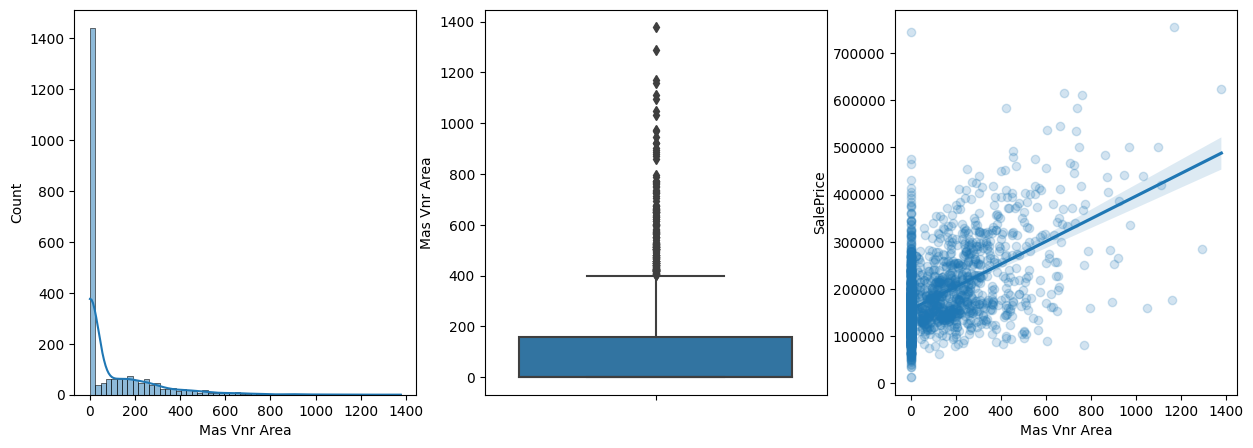

BsmtFin SF 2


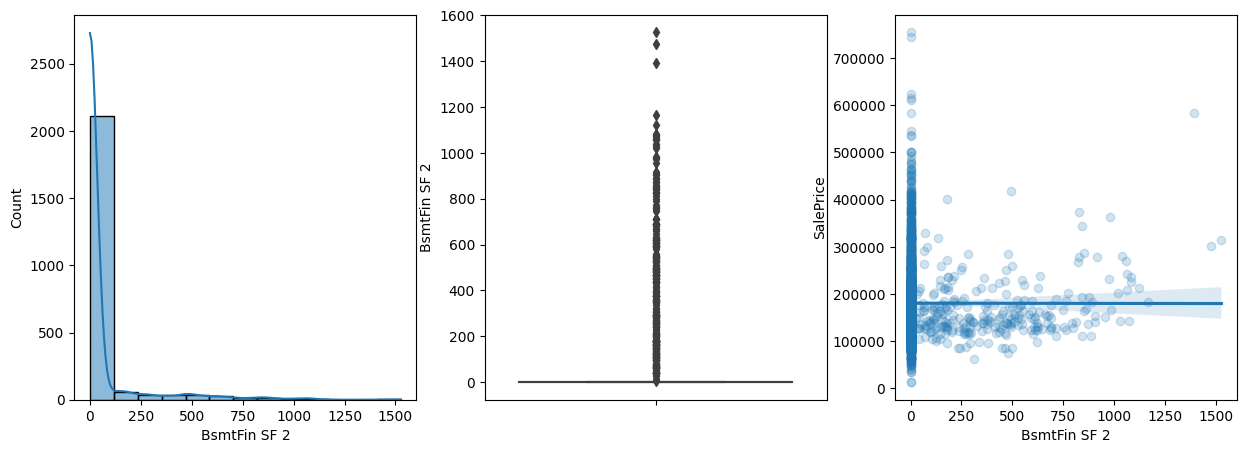

Bsmt Unf SF


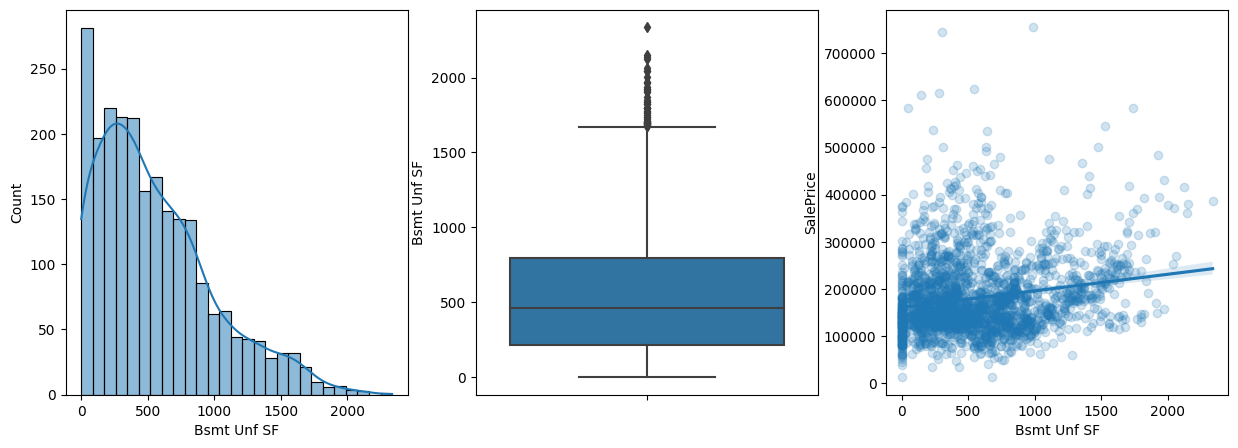

2nd Flr SF


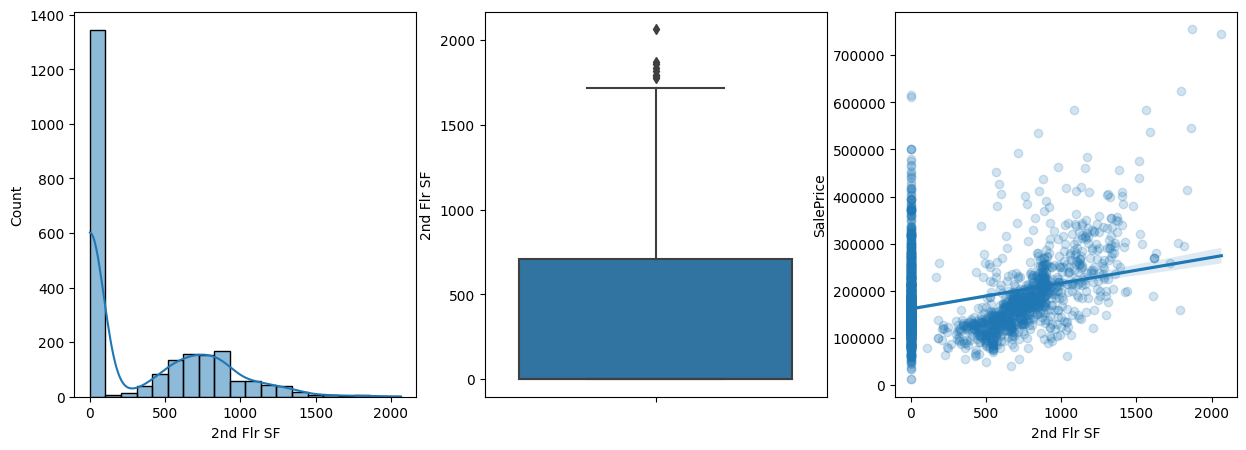

Garage Area


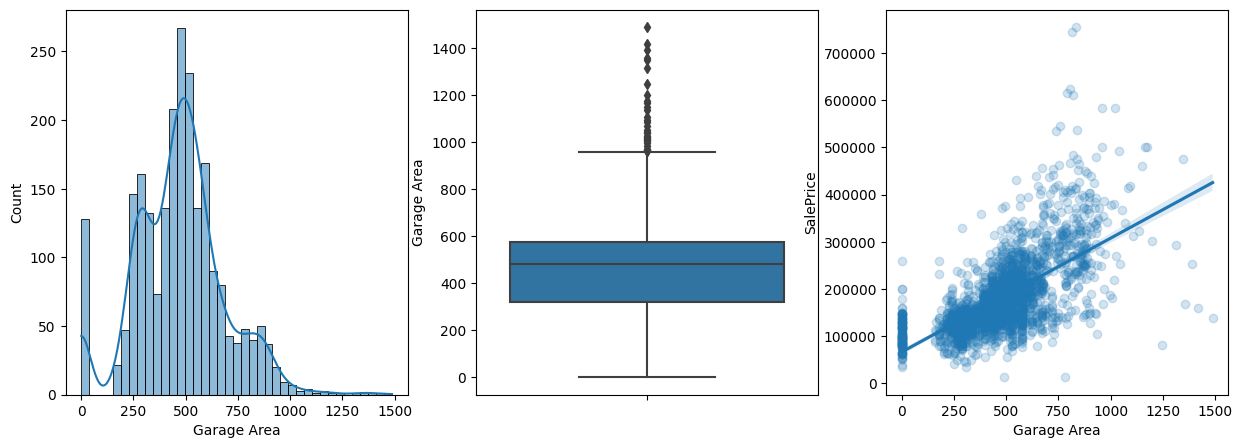

years_until_remod


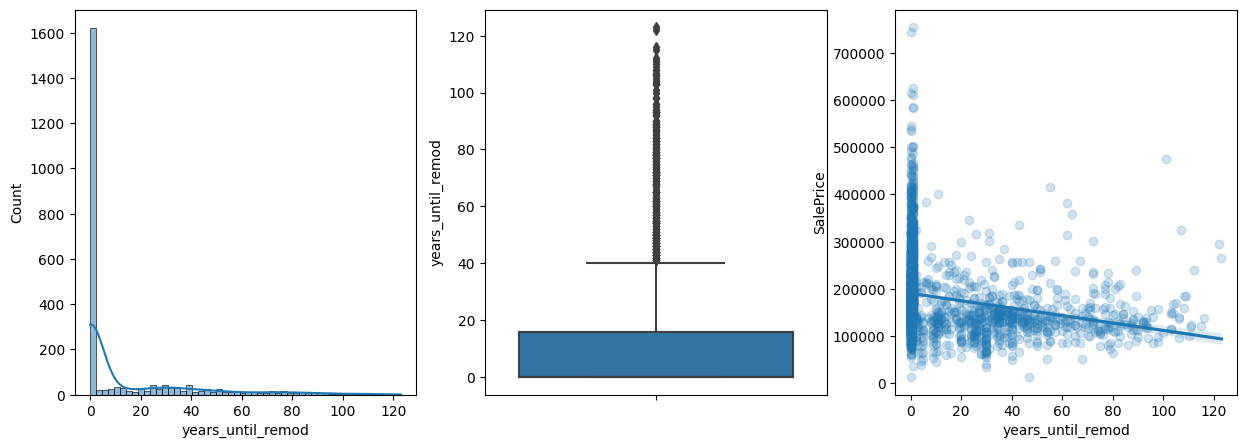

years_remod_to_sale


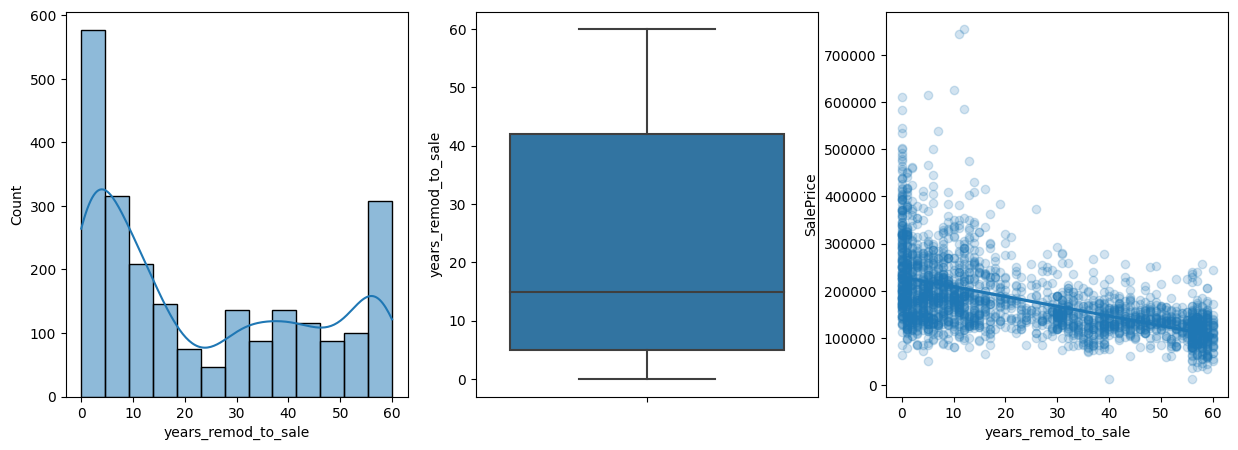

years_built_to_sale


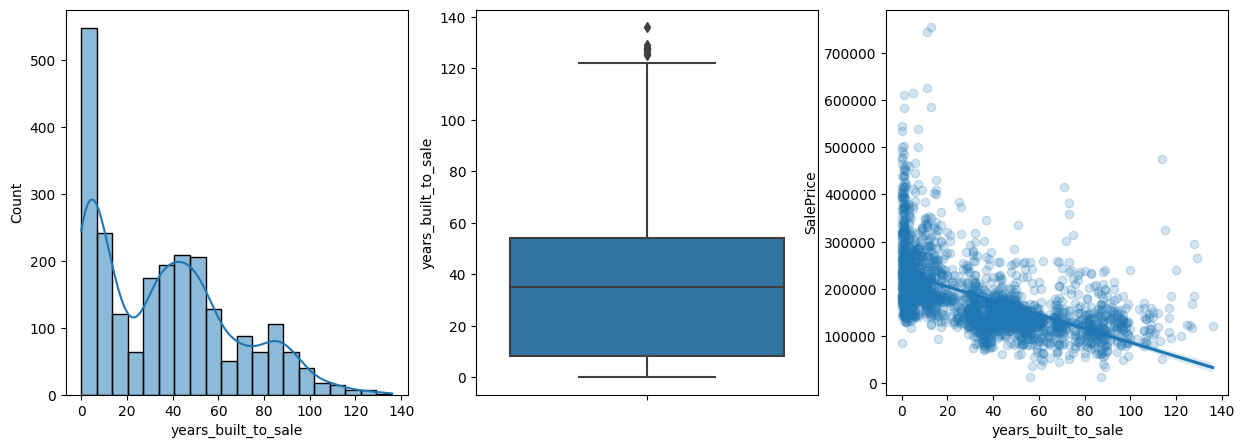

Floor_area_ratio


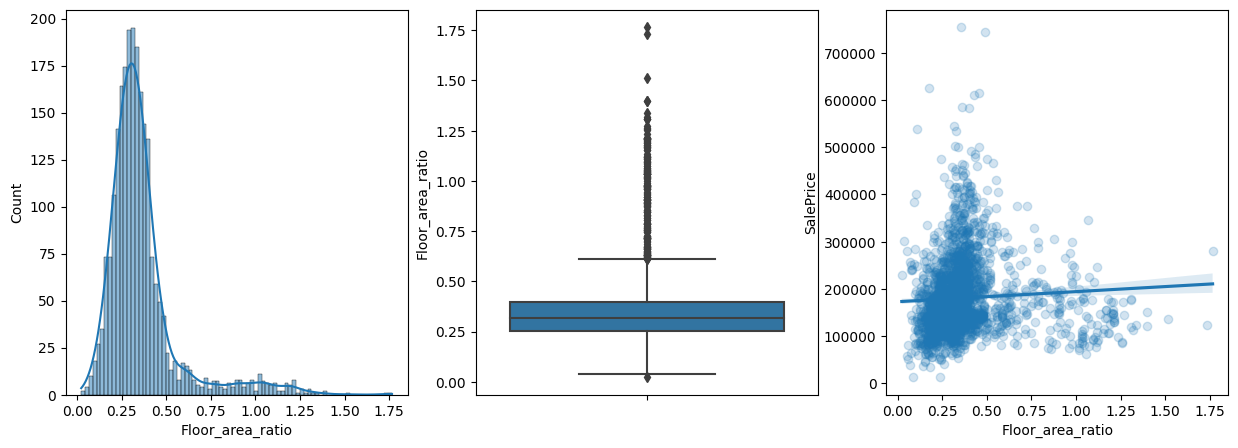

In [38]:
# Visual representation od independent variables

for var in continuous:
    print(var)
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    sn.histplot(X_train_valid[var].dropna(), kde=True, ax=ax[0])
    sn.boxplot(y=X_train_valid[var], ax=ax[1])
    sn.regplot(data=X_train_valid, x=var, y=y_train_valid, scatter_kws={'alpha':0.2})
    plt.show()

We can see that most of data is not coming from normal distribution. Also most of variables have lots of outliers. Transformation of independent variables is recommended.

#### 4.4 Eliminating unwanted characteristics - high correlation

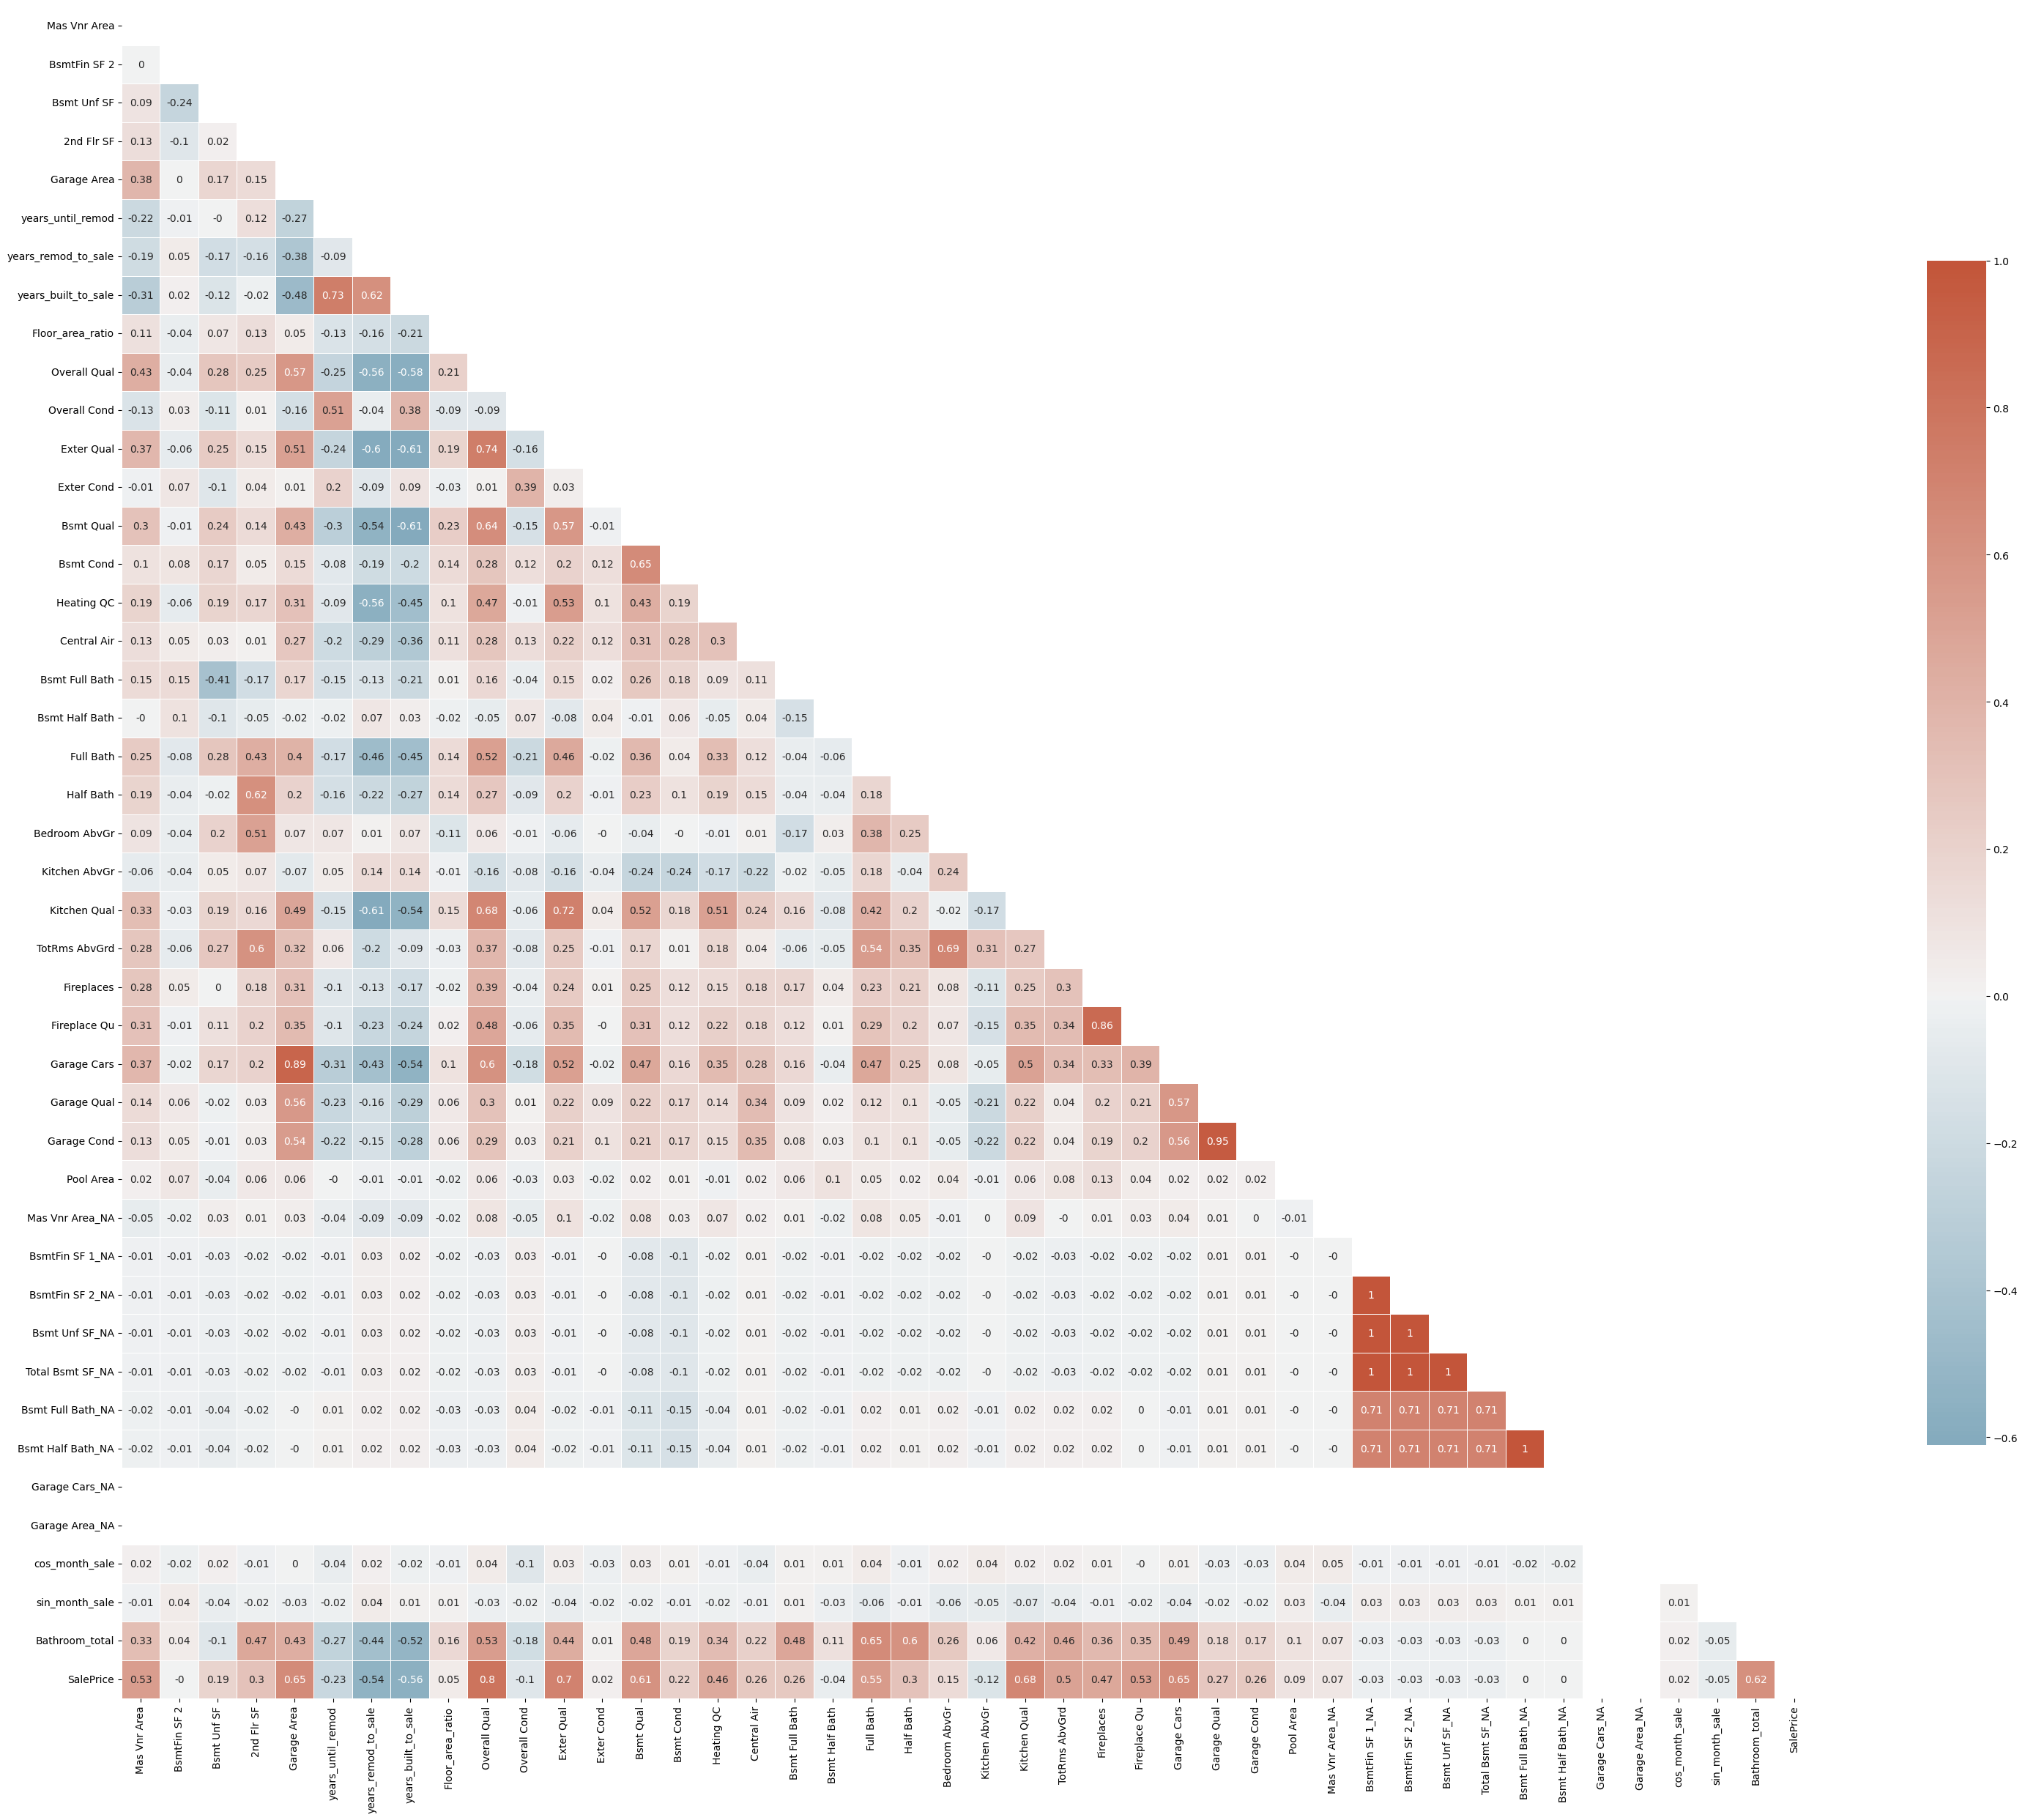

In [39]:
f, ax = plt.subplots(figsize=(40, 30))
mat = round(X_train_valid[features].merge(y_train_valid, left_index = True, right_index = True).corr('pearson'),2)
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [40]:
# Finding potentially statistically significant (> abs(strong_correlation_param) ) Pearson correlations 
matrix = mat.where(np.triu(np.ones(mat.shape)).astype(bool))
strong_corr_df = matrix.stack().reset_index()
strong_corr_df.columns = ["Var1","Var2","Correlation"]
strong_corr_df["Correlation_abs"]=abs(strong_corr_df["Correlation"])
strong_corr_df.sort_values("Correlation_abs", inplace = True, ascending=False)
strong_corr_df = strong_corr_df[strong_corr_df["Var1"] != strong_corr_df["Var2"]] # removing correlations with self
strong_corr_df = strong_corr_df[strong_corr_df["Var1"].str.contains("_NA") == False] # removing correlations with dummy _NA variables
strong_corr_df = strong_corr_df[abs(strong_corr_df["Correlation"]) > strong_correlation_param]
print(str(strong_corr_df.shape[0]) + ' potentially statistically significant correlations')
strong_corr_df

3 potentially statistically significant correlations


,Var1,Var2,Correlation,Correlation_abs
799,Garage Qual,Garage Cond,0.95,0.95
185,Garage Area,Garage Cars,0.89,0.89
751,Fireplaces,Fireplace Qu,0.86,0.86


We can observe multiple strong (>0.8 or < -0.8) correlations. Short summary:
* 1306 - Garage Quality seems strongly correlated with Garage Condition (both measured on a ordinal scale) - possibly they reflect same data, so one of those might be redundant
* 578 - Garage area is strongly correlated with number of cars that particular garage can store - obvious
* 1282 - number of fireplaces is connected with fireplace quality

In [41]:
# MANUAL_INPUT
# Dropping highly correlated variables from features list

for var in ["Garage Qual","Garage Cars","Fireplace Qu","Gr Liv Area","Total Bsmt SF"]:
    for lists in [continuous, features, discrete]:
        try:
            lists.remove(var)
            print(var,'removed from the list.')
        except:
            print(var,'is not on the list.') 

Garage Qual is not on the list.
Garage Qual removed from the list.
Garage Qual removed from the list.
Garage Cars is not on the list.
Garage Cars removed from the list.
Garage Cars removed from the list.
Fireplace Qu is not on the list.
Fireplace Qu removed from the list.
Fireplace Qu removed from the list.
Gr Liv Area is not on the list.
Gr Liv Area is not on the list.
Gr Liv Area is not on the list.
Total Bsmt SF is not on the list.
Total Bsmt SF is not on the list.
Total Bsmt SF is not on the list.


#### 4.5 Target variable analysis and transformationm

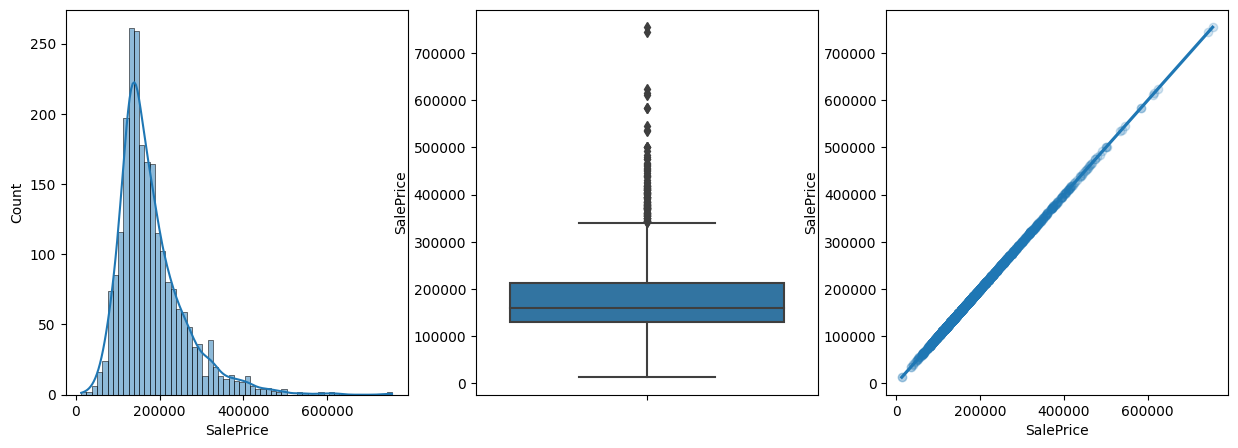

In [42]:
# Visual representation od target variable
fig,ax=plt.subplots(1,3,figsize=(15,5))
sn.histplot(y_train_valid, kde=True, ax=ax[0])
sn.boxplot(y=y_train_valid, ax=ax[1])
sn.regplot(data=y_train_valid, x=y_train_valid, y=y_train_valid, scatter_kws={'alpha':0.2})
plt.show()

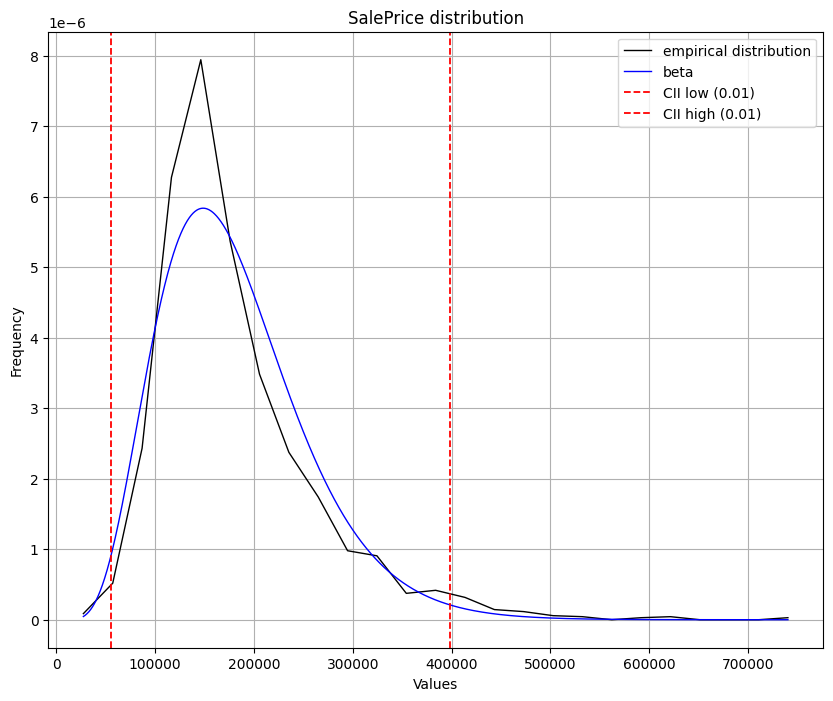

,distr,score,LLE,loc,scale,arg
0,beta,0.148617,NaN,7617.998147,175019820388073280.0,"(5.430892672079526, 5494446168642.1)"
1,dweibull,0.322892,NaN,162259.866684,57572.257467,"(1.0565869685325044,)"
2,genextreme,0.322892,NaN,-12855.472292,160488.617718,"(0.20297352622893103,)"
3,loggamma,0.322892,NaN,-25631294.12118,3463136.403422,"(1725.8387011302857,)"
4,norm,0.545091,NaN,180364.800427,79943.434305,()
5,t,0.545091,NaN,180357.541466,79943.936027,"(29106257.140585788,)"
6,gamma,0.545091,NaN,-1249052.007424,4119.582047,"(346.9678612734183,)"
7,expon,1.108472,NaN,12789.0,167575.800427,()
8,lognorm,1.448411,NaN,12789.0,5.056262,"(10.888185136336912,)"
9,pareto,2.250696,NaN,12789.0,0.0,"(0.0259468197579538,)"


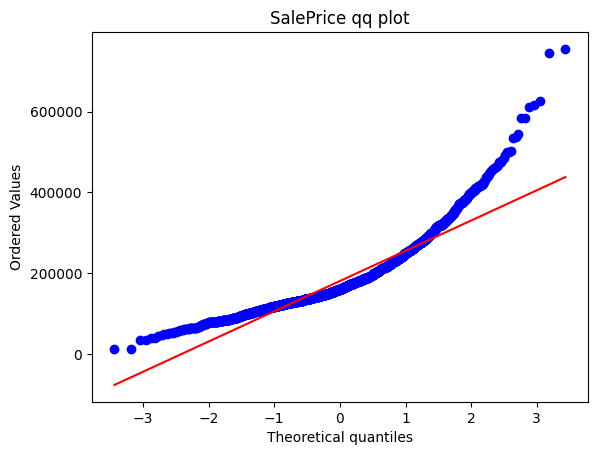

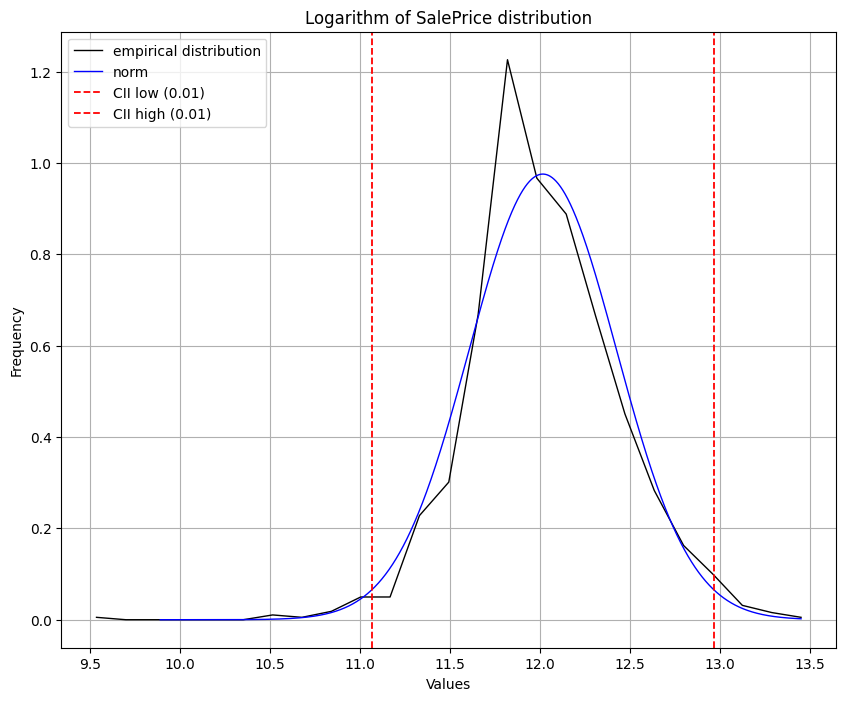

,distr,score,LLE,loc,scale,arg
0,norm,0.148617,NaN,12.01805,0.408878,()
1,dweibull,0.148617,NaN,12.005812,0.336248,"(1.219910644611828,)"
2,t,0.148617,NaN,12.014505,0.363196,"(9.42236265264598,)"
3,genextreme,0.148617,NaN,11.866643,0.421279,"(0.24253393044211607,)"
4,gamma,0.148617,NaN,-23.749166,0.004679,"(7644.748816733736,)"
5,lognorm,0.148617,NaN,-35.824169,47.841134,"(0.008553859237725786,)"
6,beta,0.148617,NaN,-632.675349,780.972352,"(433837.58758507064, 91707.04662144263)"
7,loggamma,0.148617,NaN,-68.017806,11.886516,"(840.4341407046395,)"
8,expon,3.228419,NaN,9.456341,2.561709,()
9,pareto,3.228419,NaN,-268435446.543659,268435456.0,"(104787648.62489794,)"


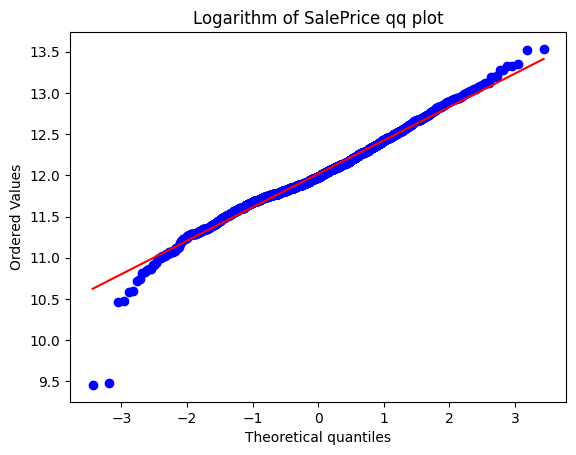

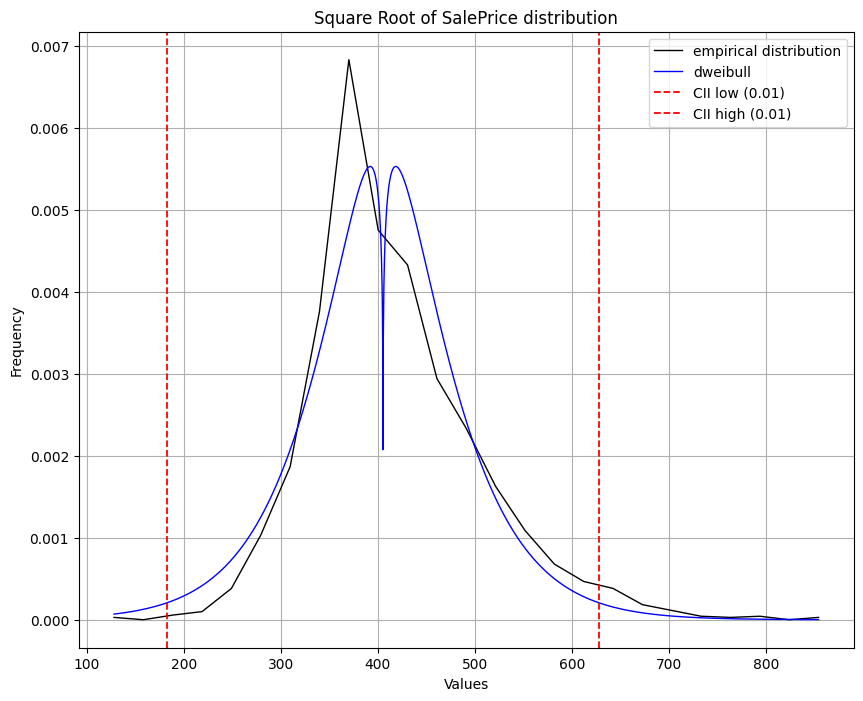

,distr,score,LLE,loc,scale,arg
0,dweibull,0.001945,NaN,405.20807,69.255291,"(1.1677345039545033,)"
1,t,0.001945,NaN,418.498789,81.456589,"(11.601301880385446,)"
2,loggamma,0.038582,NaN,-24166.232741,3383.956465,"(1428.6893628119196,)"
3,norm,0.148617,NaN,415.709934,86.891031,()
4,genextreme,0.148617,NaN,379.363296,75.409387,"(0.09352457220590016,)"
5,lognorm,0.148617,NaN,-43.359242,451.272182,"(0.18427632510367703,)"
6,beta,0.148617,NaN,99.626869,984.728017,"(8.23988419402217, 17.357117900875885)"
7,gamma,0.322892,NaN,40.176375,19.260999,"(19.497097080445023,)"
8,expon,1.828622,NaN,113.088461,302.621473,()
9,pareto,1.828622,NaN,-34359738254.911537,34359738367.999996,"(113540319.58611798,)"


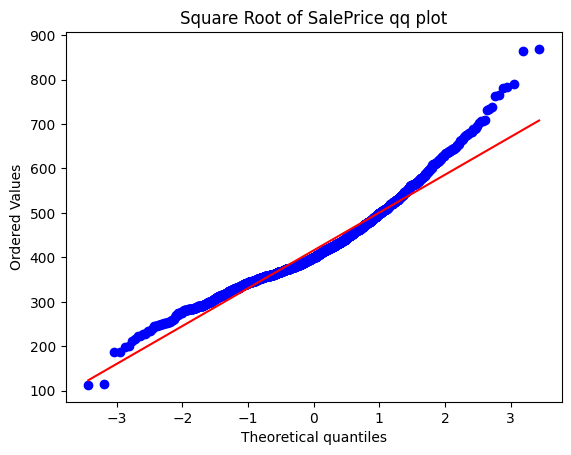

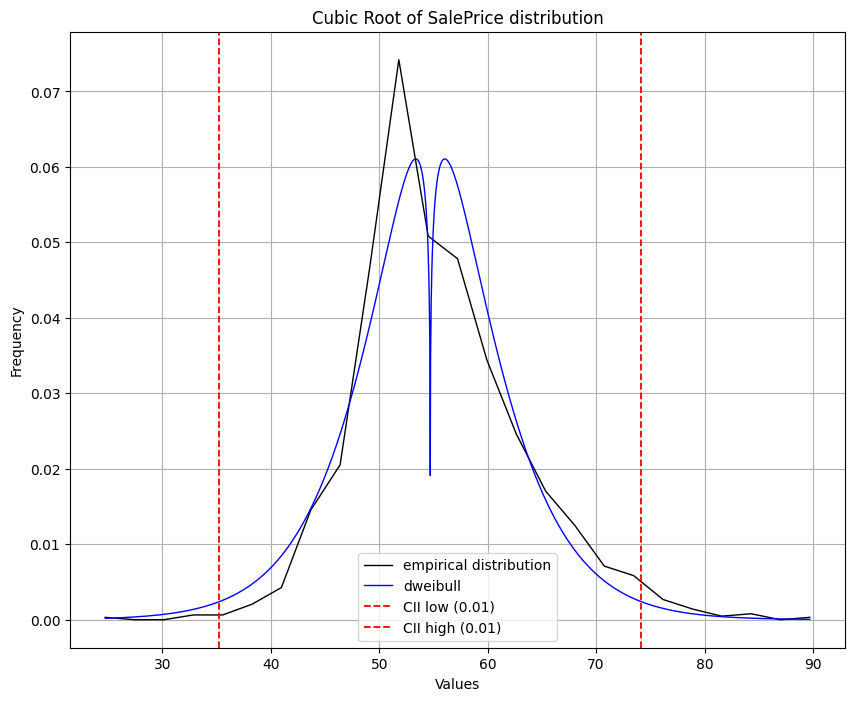

,distr,score,LLE,loc,scale,arg
0,dweibull,0.001945,NaN,54.706473,6.191738,"(1.1920708664835395,)"
1,t,0.001945,NaN,55.510049,7.599387,"(18.852075972059453,)"
2,norm,0.038582,NaN,55.440753,7.631849,()
3,genextreme,0.038582,NaN,52.363939,7.064489,"(0.14602020473531907,)"
4,gamma,0.038582,NaN,6.340588,1.163854,"(42.18755078064983,)"
5,lognorm,0.038582,NaN,-6.868894,61.853467,"(0.12098192337797896,)"
6,beta,0.038582,NaN,10.657159,3579638.227474,"(34.516173961443116, 2758389.246941475)"
7,loggamma,0.038582,NaN,-2230.511067,310.39647,"(1579.6357118493142,)"
8,expon,2.250696,NaN,23.385439,32.055314,()
9,pareto,2.250696,NaN,-2147483624.614561,2147483648.0,"(66993063.6132045,)"


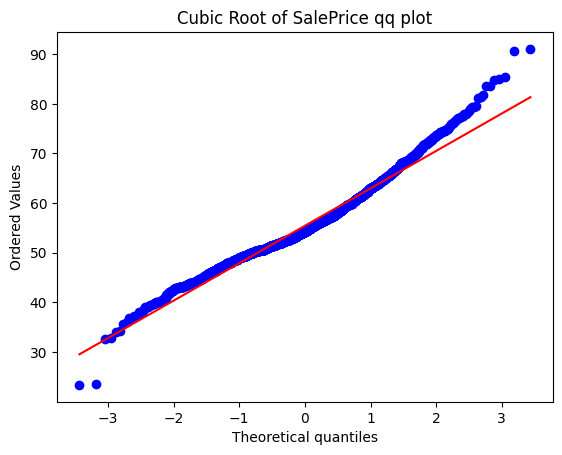

In [43]:
# Distribution fitting of target variable
# Check best fitted distribution to logarithm of target variable (variable is continuous so we suspect that logarithm
# will allow to smooth the effect of outliers, hence will be more similar to normal distribution)

for data_in, name in zip([y_train_valid, np.log(y_train_valid), np.sqrt(y_train_valid), y_train_valid**(1/3)],
                         [target,'Logarithm of ' + target,'Square Root of ' + target, 'Cubic Root of ' + target]):
    dist = distfit.distfit(bins=25,alpha=0.01,stats='ks')
    dist.fit_transform(data_in,verbose=1)
    dist.plot(verbose=1)
    plt.title(str(name) + ' distribution')
    plt.show()

    display(HTML(dist.summary.to_html()))

    stats.probplot(data_in, dist="norm", plot=pylab)
    pylab.title(str(name) + ' qq plot')
    pylab.show()

Based on plot analysis we can see that logarithm of Sale Price is most similar to normal distribution. Having said that qqplot suggest heavy tails, so we should treat our sample for outliers.

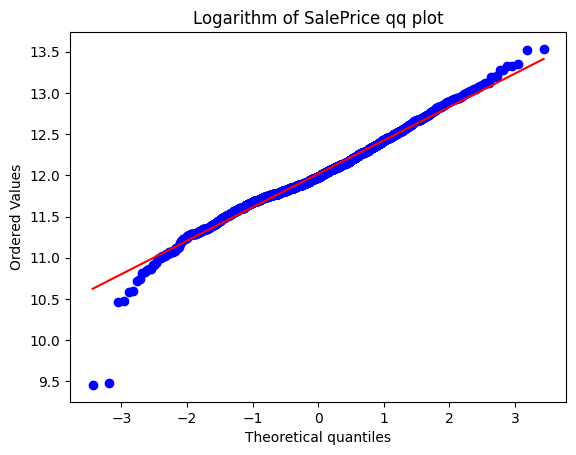

count    2340.000000
mean       12.018050
std         0.408965
min         9.456341
25%        11.767568
50%        11.982304
75%        12.271357
max        13.534473
Name: SalePrice, dtype: float64


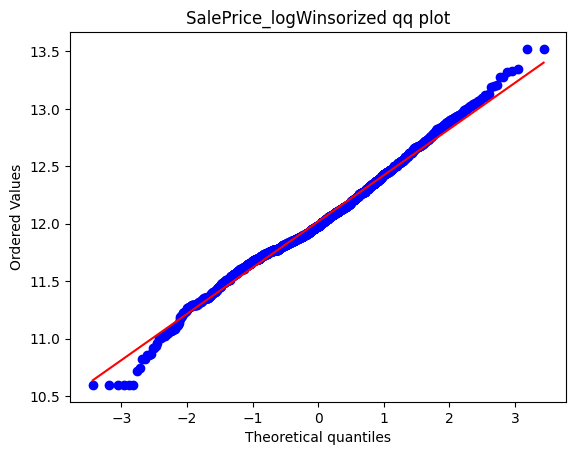

count    2340.000000
mean       12.019127
std         0.403794
min        10.596635
25%        11.767568
50%        11.982304
75%        12.271357
max        13.521139
Name: SalePrice_logWinsorized, dtype: float64


In [44]:
#MANUAL_INPUT
# Winsorizing target variable to limit outlier values impact
y2_train_valid = pd.Series(mstats.winsorize(np.log(y_train_valid), limits=[0.0025, 0.0008]), name = 'SalePrice_logWinsorized')

stats.probplot(np.log(y_train_valid), dist="norm", plot=pylab)
pylab.title('Logarithm of ' + target + ' qq plot')
pylab.show()
print(np.log(y_train_valid).describe())

stats.probplot(y2_train_valid, dist="norm", plot=pylab)
pylab.title(y2_train_valid.name + ' qq plot')
pylab.show()
print(y2_train_valid.describe())

QQ-plot characteristics seems to improve slightly after winsorizing target variable. We will try to estimate our model on both versions of target variables and see which performs better.

#### 4.6 Feature Engineering - based on sample characteristics

#### 4.6.1 Binning and Weight of Evidence transformation (WoE)

In [49]:
# Create optimal bins for Weight of Evidence Feature Engineering for categorical variables
data_optbin = gp23feat.FeatureBinning(X_df = X_train_valid, y = y_train_valid, var_list = categorical)

float64 float64
MS SubClass - IV weak predictive power -  0.03896243692507361
float64 float64
MS Zoning - IV weak predictive power -  0.024664788782739575
float64 float64
Lot Shape - IV not useful for prediction -  0.01769559438613844
Land Contour - IV not useful for prediction -  0.0021415431469726455
float64 float64
Lot Config - IV not useful for prediction -  0.0010055435902356438
float64 float64
Neighborhood - IV medium predictive power -  0.10008035502736255
float64 float64
Condition 1 - IV not useful for prediction -  0.00601839712526384
float64 float64
Condition 2 - IV not useful for prediction -  4.497382514205542e-06
Bldg Type - IV not useful for prediction -  0.007539365497111681
float64 float64
House Style - IV not useful for prediction -  0.010908074808971067
float64 float64
Roof Style - IV not useful for prediction -  0.000131001183335396
float64 float64
Roof Matl - IV not useful for prediction -  0.0013941058899317848
float64 float64
Exterior 1st - IV weak predictive powe

In [50]:
# WoE transformation for categorical variables
for i in categorical :
    X_train_valid["WOE_"+i] = data_optbin.transform(data = X_train_valid, var_name = i)
    try:
        features.remove(i)
    except:
        print(i,'is already removed from features list.') 
    # For some reason this keeps adding WOE_ vars in loop :( not sure why)
    if "WOE"+i not in X_train_valid:
        try:
            features.append("WOE_"+i)
        except:
            print("WOE_"+i,'is already in features list.')      
    else:
        print("WOE_"+i,'is already in features list.') 

In [55]:
# CHECK WoE Transformation check 
print(data_optbin.optbin_dict["Garage Type"]["bin_table"][["Bin", "WoE"]])
print(X_train_valid[["WOE_Garage Type","Garage Type"]].drop_duplicates(subset=["WOE_Garage Type","Garage Type"], keep='first'))

                      Bin       WoE
0               [Missing] -0.529127
1       [Detchd, Basment] -0.311368
2       [Attchd, BuiltIn]  0.142229
3       [2Types, CarPort] -0.274447
4                 Special  0.000000
5                 Missing  0.000000
Totals                     0.000000
      WOE_Garage Type Garage Type
2597        -0.311368      Detchd
2827        -0.311368     Basment
2065         0.142229      Attchd
2627        -0.529127     Missing
1078         0.142229     BuiltIn
2865        -0.274447      2Types
2878        -0.274447     CarPort


In [ ]:
# Box-Cox power transformation for continuous variables
boxCox_dict = {}

for i in continuous :
    X_train_valid["Box_"+i] = boxcox_transformation(data = X_train_valid, var_name = i, 
                                                    transformation_dict = boxCox_dict)
    try:
        features.append("Box_"+i)
    except:
        print("Box_"+i,'is already in features list.')     